In [2]:
#importing python libs

import sympy as sym
sym.init_printing()

import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate
import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

%load_ext cython
import time

In [3]:
#define some s pre/post operators

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

In [4]:
delo,delm=sym.symbols('delta_o delta_mu', real=True) #detunings between input and cavity
delao, delam =sym.symbols('delta_a_o delta_a_mu') #detunings between atom and cavity
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False) #energy decay for atom levels
Omega=sym.symbols('Omega', real=False, negative=False) #pump Rabi frequency
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33') #Density matrix elements
a, b = sym.symbols('a b') #classical amplitudes of the optical and microwave fields
#ar,ai=sym.symbols('a_r a_i', real=True)
go, gm=sym.symbols('g_o, g_mu',real=False, negative=False) #coupling strengths for optical and microwave fields
lam=sym.symbols('lambda')

In [5]:
H_sys=Omega*s32+gm*s21*b+go*s31*a
H_sys=H_sys+Dagger(H_sys)
H_sys=H_sys+(delao -delo)*s33+(delam-delm)*s22

In [6]:
H_sys.det()

In [7]:
s33*s31

⎡0  0  0⎤
⎢       ⎥
⎢0  0  0⎥
⎢       ⎥
⎣1  0  0⎦

In [6]:
LH=-I*spre(H_sys)+I*spost(H_sys)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*nbath*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L=LH + L21 + L12 + L32 + L31 + L22 + L33

L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
L.row_del(1)

#define the density matrix in square and row form
#the row form is so the Liovillian in matrix form can be acted on it
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]

In [8]:
LH 

⎡                 _ ___            _ __                                       
⎢   0          -ⅈ⋅b⋅gₘᵤ         -ⅈ⋅a⋅gₒ          ⅈ⋅b⋅gₘᵤ         0            
⎢                                                                             
⎢                                    _                                        
⎢-ⅈ⋅b⋅gₘᵤ  -ⅈ⋅(δₐ ₘᵤ - δₘᵤ)       -ⅈ⋅Ω              0         ⅈ⋅b⋅gₘᵤ         
⎢                                                                             
⎢-ⅈ⋅a⋅gₒ         -ⅈ⋅Ω        -ⅈ⋅(δₐ ₒ - δₒ)         0            0            
⎢                                                                             
⎢  _ ___                                                         _ ___        
⎢ⅈ⋅b⋅gₘᵤ          0                0         ⅈ⋅(δₐ ₘᵤ - δₘᵤ)  -ⅈ⋅b⋅gₘᵤ        
⎢                                                                             
⎢                _ ___                                                        
⎢   0          ⅈ⋅b⋅gₘᵤ             0            -ⅈ⋅b

In [50]:
Lfunc = sym.lambdify((a,b,delo, delm,delao, delam, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),L)


In [51]:
rhoflat

In [52]:
aval=0
bval=0
Deloval=0
Delmuval=0

In [53]:
def steady_rho_single(delaoval,delamval,aval, bval,deloval,delmval,p):

    L_mat=Lfunc(aval, bval,deloval,delmval, delaoval,delamval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return np.reshape(rho,(3,3),order='F')
def steady_rho_ensemble(delaovals,delamvals,aval, bval,deloval,delmval,p):
    ndelao=len(delaovals)
    ndelam=len(delamvals)
    coh_vals=np.zeros((3,3,ndelao,ndelam), dtype=np.complex_)
    for ii in range(ndelao):
        for jj in range(ndelam):
            coh_vals[:,:,ii,jj]=steady_rho_single(delaovals[ii],delamvals[jj],aval,bval,deloval,delmval,p)
    return coh_vals


In [54]:
def integrate1d_peaks(func,x,ylims, peak_func,aval,bval,deloval,delmval,p):
    peak_yval=peak_func(x)
    
    if (np.isnan(peak_yval) or peak_yval>ylims[1] or peak_yval<ylims[0]):
        funcval=scipy.integrate.quad(func, ylims[0], ylims[1], args=(x,aval,bval,deloval,delmval,p))[0]
        
    else:
        funcval1=scipy.integrate.quad(func, ylims[0], peak_yval, args=(x,aval,bval,deloval,delmval,p))[0]
        funcval2=scipy.integrate.quad(func, peak_yval, ylims[1], args=(x,aval,bval,deloval,delmval,p))[0]
        funcval=funcval1+funcval2
    return funcval

def integrate2d_peaks(func, ylims, xlims, peak_func,aval,bval,deloval,delmval,p):
    temp_fun=lambda x: integrate1d_peaks(func, x, ylims, peak_func,aval,bval,deloval,delmval,p)
    inte=scipy.integrate.quad(temp_fun,xlims[0], xlims[1])
    return inte

In [55]:
coh13_Rfun=lambda delaoval, delamval,aval, bval,deloval,delmval,p: np.real(steady_rho_single(delaoval,delamval,aval,bval,deloval,delmval,p)[0,2])
coh13_Ifun=lambda delaoval, delamval,aval, bval,deloval,delmval,p: np.imag(steady_rho_single(delaoval,delamval,aval,bval,deloval,delmval,p)[0,2])
gauss_fun=lambda delaoval, delamval, mo,mm,sdo,sdm: 1.0/(2*pi*sdo*sdm)*np.exp(-(delaoval-mo)**2/(2*sdo**2)
                                                                  -(delamval-mm)**2/(2*sdm**2))
coh13_Rguass_fun=lambda delaoval, delamval,aval, bval,deloval,delmval,p: coh13_Rfun(delaoval, delamval,aval, bval,deloval,delmval,p)*gauss_fun(delaoval,delamval,p['mean_delao'], p['mean_delam'],p['sd_delao'],p['sd_delam'])  
coh13_Iguass_fun=lambda delaoval, delamval,aval, bval,deloval,delmval,p: coh13_Ifun(delaoval, delamval,aval, bval,deloval,delmval,p)*gauss_fun(delaoval,delamval,p['mean_delao'], p['mean_delam'],p['sd_delao'],p['sd_delam'])  


In [56]:
coh12_Rfun=lambda delaoval, delamval,aval, bval,deloval,delmval,p: np.real(steady_rho_single(delaoval,delamval,aval,bval,deloval,delmval,p)[0,1])
coh12_Ifun=lambda delaoval, delamval,aval, bval,deloval,delmval,p: np.imag(steady_rho_single(delaoval,delamval,aval,bval,deloval,delmval,p)[0,1])
coh12_Rguass_fun=lambda delaoval, delamval,aval, bval,deloval,delmval,p: coh12_Rfun(delaoval, delamval,aval, bval,deloval,delmval,p)*gauss_fun(delaoval,delamval,p['mean_delao'], p['mean_delam'],p['sd_delao'],p['sd_delam'])  
coh12_Iguass_fun=lambda delaoval, delamval,aval, bval,deloval,delmval,p: coh12_Ifun(delaoval, delamval,aval, bval,deloval,delmval,p)*gauss_fun(delaoval,delamval,p['mean_delao'], p['mean_delam'],p['sd_delao'],p['sd_delam'])  


In [296]:
steady_rho_single(0,0,0,1,0,0,p)

matrix([[ 0.51219512+0.00000000e+00j, -0.        +5.06328525e-08j,
          0.        -0.00000000e+00j],
        [ 0.        -5.06328525e-08j,  0.48780488+0.00000000e+00j,
          0.        -0.00000000e+00j],
        [ 0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
          0.        -0.00000000e+00j]])

In [76]:
scipy.integrate.nquad(gauss_fun,[[-np.inf,np.inf],[-np.inf,np.inf]], args=(0,0,10000,10000))

/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [57]:
def rho13_integrated(delao_lims, delam_lims,aval,bval,deloval,delmval,p, peak_func):
    coh13_R_int=integrate2d_peaks(coh13_Rguass_fun, delao_lims, delam_lims, peak_func,aval,bval,deloval,delmval,p)
    coh13_I_int=integrate2d_peaks(coh13_Rguass_fun, delao_lims, delam_lims, peak_func,aval,bval,deloval,delmval,p)
    #return [coh13_R_int, coh13_I_int]#coh13_R_int+1.j*coh13_I_int\
    #return coh13_R_int+1.j*coh13_I_int
    return coh13_R_int[0]+1.j*coh13_I_int[0],coh13_R_int[1]+1.j*coh13_I_int[1]
def rho13_integrated_quad(delao_lims, delam_lims,aval,bval,deloval,delmval,p):
    coh13_R_int=scipy.integrate.nquad(coh13_Rguass_fun, [delao_lims,delam_lims],args=(aval,bval,deloval,delmval,p))[0]
    coh13_I_int=scipy.integrate.nquad(coh13_Iguass_fun, [delao_lims,delam_lims],args=(aval,bval,deloval,delmval,p))[0]
    #return [coh13_R_int, coh13_I_int]#coh13_R_int+1.j*coh13_I_int\
    return coh13_R_int+1.j*coh13_I_int

In [58]:
def rho12_integrated(delao_lims, delam_lims,aval,bval,deloval,delmval,p, peak_func):
    coh12_R_int=integrate2d_peaks(coh12_Rguass_fun, delao_lims, delam_lims, peak_func,aval,bval,deloval,delmval,p)
    coh12_I_int=integrate2d_peaks(coh12_Rguass_fun, delao_lims, delam_lims, peak_func,aval,bval,deloval,delmval,p)
    #return [coh13_R_int, coh13_I_int]#coh13_R_int+1.j*coh13_I_int\
    #return coh13_R_int+1.j*coh13_I_int
    return coh12_R_int[0]+1.j*coh12_I_int[0],coh12_R_int[1]+1.j*coh12_I_int[1]
def rho12_integrated_quad(delao_lims, delam_lims,aval,bval,deloval,delmval,p):
    coh12_R_int=scipy.integrate.nquad(coh12_Rguass_fun, [delao_lims,delam_lims],args=(aval,bval,deloval,delmval,p))[0]
    coh12_I_int=scipy.integrate.nquad(coh12_Iguass_fun, [delao_lims,delam_lims],args=(aval,bval,deloval,delmval,p))[0]
    #return [coh13_R_int, coh13_I_int]#coh13_R_int+1.j*coh13_I_int\
    return coh12_R_int+1.j*coh12_I_int

In [59]:
rho12_integrated_quad([-np.inf, np.inf],[-np.inf,np.inf],1,-1j,1.4,300,p)
rho13_integrated_quad([-np.inf, np.inf],[-np.inf,np.inf],1,-1j,1.4,300,p)

(-3.988518189875969e-10+1.4282351173766749e-06j)

In [60]:
# calculate optical rabi frequency from power in in dBm
def omega_from_Pin(Pin,p):
    epsilon0=8.854187817e-12
    hbar=1.05457e-34; # in J*s

    optP = 1e-3 * 10**(Pin/10) #incident optical power in W
    pflux = optP/(2*pi*p['freq_pump']*hbar) #photon flux (photons/sec)
    n_in = pflux * p['kappaoc']*4/(p['kappaoc']+p['kappaoi'])**2 # num intracavity photons
                                                #is this right????
    Sspot = pi*p['Wcavity']**2 #cross sectional area of
                                #optical mode
    V_cav = (Sspot*p['Lcavity_vac']+Sspot*p['Lsample']*p['nYSO']**3)/2;
    optEfield = math.sqrt(n_in*hbar*2*pi*p['freq_pump']/2/epsilon0/V_cav);
    p['Omega'] = p['d23']*optEfield/hbar*(-1);
    return p['Omega']

In [320]:
aval=0
bval=0

p = {}

p['deltamu'] = 0.
p['deltao'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['go'] = 51.9  #optical coupling

p['No'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for 
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
#p['df']=0.1e6 # how small descretisation step to take when integrating over the 
            # inhomogeneous lines

p['mean_delam']=0
p['sd_delam']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nm'] = 2.22e16  #toal number of atoms
p['gm'] = 1.04 #coupling between atoms and microwave field

p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
p['gammamc']=2*pi*70e3
p['gammami']=2*pi*650e3


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqmu'] = 5.186e9
p['freq_pump'] = 195113.36e9 #pump frequency
p['freqo']=p['freqmu']+p['freq_pump']

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76
omega_from_Pin(0,p)

In [62]:
S13= lambda aval,bval,delo,delm,p: p['go']*p['No']*rho13_integrated_quad([-np.inf, np.inf],[-np.inf,np.inf],aval,bval,delo,delm,p)   
S12= lambda aval,bval,delo,delm,p : p['gm']*p['Nm']*rho12_integrated_quad([-np.inf, np.inf],[-np.inf,np.inf],aval,bval,delo,delm,p)    

In [64]:
S13(100,-3+7j,10000,-1896,p)

(4.139128503081473+361.3002051509277j)

In [65]:
def output_vec_func(out_vec,ainval,binval,deloval,delmval):
    aout1=out_vec[0]+1j*out_vec[1]
    bout1=out_vec[2]+1j*out_vec[3]
    aval=(ainval+aout1)/np.sqrt(p['gammaoc'])
    bval=(binval+bout1)/np.sqrt(p['gammamc'])
    
    aout=(-1j*np.sqrt(p['gammaoc'])*S13(aval,bval,deloval,delmval,p)+((p['gammaoc']-p['gammaoi'])/2+1j*deloval)*ainval)/((p['gammaoc']+p['gammaoi'])/2-1j*deloval)         
    
    bout=(-1j*np.sqrt(p['gammamc'])*S12(aval,bval,deloval,delmval,p)+((p['gammamc']-p['gammami'])/2+1j*delmval)*binval)/((p['gammamc']+p['gammami'])/2-1j*delmval)    
    
    output_out=[aout.real, aout.imag, bout.real, bout.imag]
    
    return output_out
    

In [26]:
p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
def find_output(ainval,binval,deloval,delmval):
    output_zero= lambda x : output_vec_func(x, ainval,binval,deloval,delmval)-x
    output_found=scipy.optimize.fsolve(output_zero,[0,0,0,0])
     
    aout_found=output_found[0]+1j*output_found[1]
    bout_found=output_found[2]+1j*output_found[3]
    
    return aout_found, bout_found

In [27]:
p

{'deltamu': 0.0,
 'deltao': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'go': 51.9,
 'No': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'mean_delam': 0,
 'sd_delam': 66700480.96793615,
 'mean_delao': 0,
 'sd_delao': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nm': 2.22e+16,
 'gm': 1.04,
 'gammaoc': 10681415.022205297,
 'gammaoi': 49951323.19207771,
 'gammamc': 439822.971502571,
 'gammami': 4084070.449666731,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqmu': 5186000000.0,
 'freq_pump': 195113360000000.0,
 'freqo': 195118546000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'Omega': -492090.88755145477}

In [28]:
delovals=np.linspace(-100e6,100e6,5)
delmvals=np.linspace(-50e6,50e6,5)
ainvals=[1,100,10000]
binvals=[1,100,10000]

aoutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_a=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
boutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, ainval in enumerate(ainvals):
            for ll, binval in enumerate(binvals):
                aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                elapsed_time=time.time()-start_time
                print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))

KeyboardInterrupt: 

In [ ]:
plt.imshow(abs(aoutvals[:,:,0,0]))
plt.colorbar()

In [ ]:
plt.imshow(abs(boutvals[:,:,0,0]))
plt.colorbar()

In [ ]:
boutvals

In [67]:
aoutvals

array([[[[-970.34350384-9.78233772e+01j]],

        [[-970.34350384-9.78233770e+01j]],

        [[-970.34350384-9.78233768e+01j]]],


       [[[-647.66792727-4.50292964e-06j]],

        [[-647.66834938-2.37161563e-06j]],

        [[-647.66792727+4.52552145e-06j]]],


       [[[-970.34350384+9.78233768e+01j]],

        [[-970.34350384+9.78233770e+01j]],

        [[-970.34350384+9.78233772e+01j]]]])

In [71]:
delovals=np.linspace(-150e6,150e6,12)*2*pi/2
delmvals=np.linspace(-25e6,25e6,12)*2*pi/2.355*3
ainvals=[100]
binvals=[100]

aoutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_a=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
boutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, ainval in enumerate(ainvals):
            for ll, binval in enumerate(binvals):
                aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                elapsed_time=time.time()-start_time
                print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))

    0, 0, 0, 0, Time: 25.537999629974365
    aout = (-99.85477881598632-2.2573241031607436j), bout = (-99.99751569824512-0.21977191745300614j)
    0, 1, 0, 0, Time: 51.63115334510803
    aout = (-99.85477881598631-2.2573241031466598j), bout = (-99.99628911669585-0.2685931748806605j)
    0, 2, 0, 0, Time: 77.44096517562866
    aout = (-99.85477881598631-2.2573241031364257j), bout = (-99.99386644714899-0.3452910470717376j)
    0, 3, 0, 0, Time: 103.56592321395874
    aout = (-99.8547788159863-2.257324103128779j), bout = (-99.9879818757676-0.4832611236709245j)
    0, 4, 0, 0, Time: 129.15041494369507
    aout = (-99.85477881598628-2.257324103122929j), bout = (-99.96665296329826-0.8045511653498966j)
    0, 5, 0, 0, Time: 154.83062505722046
    aout = (-99.85477881598628-2.257324103118318j), bout = (-99.70393860936157-2.3809865422693597j)
    0, 6, 0, 0, Time: 180.5333993434906
    aout = (-99.85477881598631-2.257324103114541j), bout = (-99.7039386093611+2.3809865422727574j)
    0, 7, 0, 0,

    4, 11, 0, 0, Time: 1541.9382297992706
    aout = (-98.14284023019013-7.873027724283012j), bout = (-99.99751569824453+0.21977191745508146j)
    5, 0, 0, 0, Time: 1567.690949678421
    aout = (-88.24321585442325-16.613448586902496j), bout = (-99.99751569822848-0.21977191742938954j)
    5, 1, 0, 0, Time: 1593.2969844341278
    aout = (-88.24321585521851-16.613448654942996j), bout = (-99.99628911667313-0.26859317484838324j)
    5, 2, 0, 0, Time: 1619.0519268512726
    aout = (-88.24321585648734-16.61344876350722j), bout = (-99.99386644711817-0.3452910470277875j)
    5, 3, 0, 0, Time: 1644.9606988430023
    aout = (-88.24321585828177-16.613448917065448j), bout = (-99.98798187572993-0.48326112361689344j)
    5, 4, 0, 0, Time: 1670.5164144039154
    aout = (-88.24321585978652-16.613449045903177j), bout = (-99.96665296326832-0.8045511653079866j)
    5, 5, 0, 0, Time: 1696.0989184379578
    aout = (-88.24321585939529-16.613449012605845j), bout = (-99.70393860933854-2.3809865422604894j)
    

    9, 10, 0, 0, Time: 3031.2862215042114
    aout = (-99.64355138298696+3.525869502071783j), bout = (-99.99628911669579+0.26859317487963735j)
    9, 11, 0, 0, Time: 3056.013825416565
    aout = (-99.6435513829876+3.5258695024600057j), bout = (-99.99751569824507+0.21977191745207958j)
    10, 0, 0, 0, Time: 3080.4712269306183
    aout = (-99.78350530796102+2.7533474716059896j), bout = (-99.99751569824514-0.21977191745266705j)
    10, 1, 0, 0, Time: 3105.270408153534
    aout = (-99.78350530796102+2.753347471609864j), bout = (-99.99628911669586-0.2685931748802561j)
    10, 2, 0, 0, Time: 3129.4776377677917
    aout = (-99.78350530796102+2.7533474716145614j), bout = (-99.993866447149-0.3452910470712228j)
    10, 3, 0, 0, Time: 3153.9867510795593
    aout = (-99.78350530796102+2.7533474716203306j), bout = (-99.98798187576767-0.48326112367019913j)
    10, 4, 0, 0, Time: 3178.4767768383026
    aout = (-99.78350530796104+2.753347471627527j), bout = (-99.96665296329839-0.8045511653486438j)
   

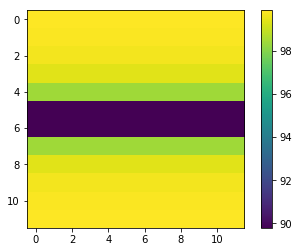

In [72]:
plt.imshow(abs(aoutvals[:,:,0,0]))
plt.colorbar()

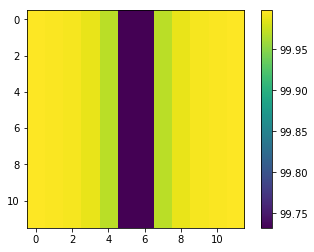

In [73]:
plt.imshow(abs(boutvals[:,:,0,0]))
plt.colorbar()

In [75]:
np.savetxt("aout_test1.csv",aoutvals.reshape(12,12),delimiter=",")
np.savetxt("bout_test1.csv",boutvals.reshape(12,12),delimiter=",")


In [87]:
delovals=np.linspace(-150e6,150e6,3)*2*pi/2
delmvals=np.linspace(-500e6,500e6,100)*2*pi/2.355*3
ainvals=[0,100]
binvals=[0,100]

aoutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_a=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
boutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, ainval in enumerate(ainvals):
            for ll, binval in enumerate(binvals):
                if (ainval+binval) ==0:
                    print('zero lol')
                else:
                    aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                    effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                    effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                    elapsed_time=time.time()-start_time
                    print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                    print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))
aoutvals_copy1=aoutvals[:]                    
boutvals_copy1=boutvals[:]
effic_a_copy1=effic_a[:]
effic_b_copy1=effic_b[:]

zero lol
zero lol


/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in cdouble_scalars


    0, 0, 1, 0, Time: 22.567978620529175
    aout = (-99.85477881598625-2.2573241030925546j), bout = (5.494096505931342e-17+8.469413106278495e-16j)
    0, 0, 1, 1, Time: 47.916736125946045
    aout = (-99.85477881598625-2.2573241030925546j), bout = (-99.99999378845398-0.01098999648923333j)
zero lol
zero lol
    0, 1, 1, 0, Time: 70.65921664237976
    aout = (-99.85477881598625-2.2573241030925755j), bout = (5.737054846289215e-17+8.845332011611099e-16j)
    0, 1, 1, 1, Time: 95.67113852500916
    aout = (-99.85477881598625-2.2573241030925755j), bout = (-99.99999352966715-0.011216594205708582j)
zero lol
zero lol
    0, 2, 1, 0, Time: 118.53834009170532
    aout = (-99.85477881598626-2.2573241030925972j), bout = (5.99652008044139e-17+9.246878734402828e-16j)
    0, 2, 1, 1, Time: 143.40193700790405
    aout = (-99.85477881598626-2.2573241030925995j), bout = (-99.99999325436447-0.01145273286893919j)
zero lol
zero lol
    0, 3, 1, 0, Time: 166.20395708084106
    aout = (-99.85477881598626-2.2

    0, 27, 1, 0, Time: 1297.238534450531
    aout = (-99.85477881598626-2.257324103095173j), bout = (3.108343479683613e-16+4.830549725477612e-15j)
    0, 27, 1, 1, Time: 1321.4159154891968
    aout = (-99.85477881598626-2.257324103095173j), bout = (-99.99996993615416-0.024177962617406536j)
zero lol
zero lol
    0, 28, 1, 0, Time: 1343.5897564888
    aout = (-99.85477881598626-2.257324103095575j), bout = (3.4545910812335943e-16+5.371690193872951e-15j)
    0, 28, 1, 1, Time: 1368.017672777176
    aout = (-99.85477881598626-2.257324103095575j), bout = (-99.99996707448413-0.025302515294397768j)
zero lol
zero lol
    0, 29, 1, 0, Time: 1390.1519131660461
    aout = (-99.85477881598626-2.257324103096061j), bout = (3.862678759668838e-16+6.009824515345461e-15j)
    0, 29, 1, 1, Time: 1414.5464749336243
    aout = (-99.85477881598626-2.2573241030960607j), bout = (-99.99996378389737-0.02653677984231621j)
zero lol
zero lol
    0, 30, 1, 0, Time: 1436.760326385498
    aout = (-99.85477881598626-2.

    0, 53, 1, 1, Time: 2532.737368822098
    aout = (-99.85477881598626-2.2573241031018036j), bout = (-99.99875764301626+0.15542006916622012j)
zero lol
zero lol
    0, 54, 1, 0, Time: 2554.9627299308777
    aout = (-99.85477881598626-2.2573241031000397j), bout = (3.0350957818488935e-15+4.1634444687032496e-14j)
    0, 54, 1, 1, Time: 2579.3202805519104
    aout = (-99.85477881598626-2.257324103100037j), bout = (-99.9992484317428+0.1208853273498509j)
zero lol
zero lol
    0, 55, 1, 0, Time: 2601.272959947586
    aout = (-99.85477881598626-2.2573241030987132j), bout = (2.1995822467289434e-15+3.07821635339101e-14j)
    0, 55, 1, 1, Time: 2625.707798242569
    aout = (-99.85477881598626-2.2573241030987115j), bout = (-99.99949687763058+0.09890744071714995j)
zero lol
zero lol
    0, 56, 1, 0, Time: 2647.9849548339844
    aout = (-99.85477881598626-2.257324103097693j), bout = (1.6762645007361332e-15+2.378864494527724e-14j)
    0, 56, 1, 1, Time: 2672.712566614151
    aout = (-99.85477881598626

    0, 80, 1, 0, Time: 3768.1852221488953
    aout = (-99.85477881598625-2.2573241030927544j), bout = (1.1125199189695404e-16+1.6762072015386207e-15j)
    0, 80, 1, 1, Time: 3792.8290028572083
    aout = (-99.85477881598625-2.257324103092754j), bout = (-99.99998363898663+0.01783621450037487j)
zero lol
zero lol
    0, 81, 1, 0, Time: 3814.746487379074
    aout = (-99.85477881598625-2.2573241030927202j), bout = (1.0475835769746364e-16+1.5791392657096608e-15j)
    0, 81, 1, 1, Time: 3839.4078664779663
    aout = (-99.85477881598625-2.2573241030927202j), bout = (-99.99998466129152+0.0172699863765989j)
zero lol
zero lol
    0, 82, 1, 0, Time: 3861.7932453155518
    aout = (-99.85477881598626-2.257324103092689j), bout = (9.881860850174885e-17+1.4902834865653323e-15j)
    0, 82, 1, 1, Time: 3886.2729635238647
    aout = (-99.85477881598626-2.2573241030926883j), bout = (-99.9999855906895+0.016738602980461634j)
zero lol
zero lol
    0, 83, 1, 0, Time: 3908.3771781921387
    aout = (-99.85477881

    1, 6, 1, 1, Time: 5004.099620103836
    aout = (-64.76667127200601-2.3124326542660744e-08j), bout = (-99.99999195675032-0.012505856910179303j)
zero lol
zero lol
    1, 7, 1, 0, Time: 5026.605575084686
    aout = (-64.76667127691927-2.366858043041242e-08j), bout = (7.645848608968322e-15-1.4979563004964918e-11j)
    1, 7, 1, 1, Time: 5051.121923208237
    aout = (-64.76667127691927-2.3667716752217534e-08j), bout = (-99.99999157379162-0.01280011211513479j)
zero lol
zero lol
    1, 8, 1, 0, Time: 5073.463928461075
    aout = (-64.76667128219165-2.4238147461444325e-08j), bout = (8.211724323992132e-15-1.5709674345523186e-11j)
    1, 8, 1, 1, Time: 5097.873016119003
    aout = (-64.76667128219165-2.4237241687152492e-08j), bout = (-99.99999116281688-0.013108548274952869j)
zero lol
zero lol
    1, 9, 1, 0, Time: 5120.220329046249
    aout = (-64.76667128785897-2.483578290524924e-08j), bout = (8.834840464547988e-15-1.6494481940657208e-11j)
    1, 9, 1, 1, Time: 5144.8616144657135
    aout = 

    1, 32, 1, 1, Time: 6224.494870185852
    aout = (-64.76667180464963-5.729531370494483e-08j), bout = (-99.99995030267225-0.0310859206365273j)
zero lol
zero lol
    1, 33, 1, 0, Time: 6249.400878429413
    aout = (-64.76667188370895-6.074447159997263e-08j), bout = (1.3018042761492708e-13-9.902340257575126e-11j)
    1, 33, 1, 1, Time: 6273.743137836456
    aout = (-64.76667188370894-6.073876220030141e-08j), bout = (-99.99994409622859-0.03296990530858839j)
zero lol
zero lol
    1, 34, 1, 0, Time: 6298.0826025009155
    aout = (-64.76667197845504-6.462689309908465e-08j), bout = (1.5694694279731743e-13-1.1214927750660012e-10j)
    1, 34, 1, 1, Time: 6322.65057182312
    aout = (-64.76667197845502-6.462042690050459e-08j), bout = (-99.999936650173-0.03509698254031354j)
zero lol
zero lol
    1, 35, 1, 0, Time: 6347.226496934891
    aout = (-64.76667209332082-6.90365181472996e-08j), bout = (1.9157603775410455e-13-1.2806357439482034e-10j)
    1, 35, 1, 1, Time: 6371.744847536087
    aout = (-

    1, 58, 1, 1, Time: 7498.780262708664
    aout = (-64.76667382982879+1.1656698805247763e-07j), bout = (-99.99978934698223+0.06399989451075473j)
zero lol
zero lol
    1, 59, 1, 0, Time: 7523.462991476059
    aout = (-64.7666733061994+1.0460757174699511e-07j), bout = (-6.761834599400725e-13-2.9617784651310403e-10j)
    1, 59, 1, 1, Time: 7547.963549613953
    aout = (-64.76667330619944+1.0462464847475435e-07j), bout = (-99.99983136051605+0.05726318727283909j)
zero lol
zero lol
    1, 60, 1, 0, Time: 7572.635279893875
    aout = (-64.76667292271677+9.486348590482003e-08j), bout = (-5.019782502180252e-13-2.4300956707293245e-10j)
    1, 60, 1, 1, Time: 7597.15478849411
    aout = (-64.7666729227168+9.487749711327726e-08j), bout = (-99.99986195249544+0.05180963192743938j)
zero lol
zero lol
    1, 61, 1, 0, Time: 7621.916875839233
    aout = (-64.76667263362053+8.676491184581694e-08j), bout = (-3.8275839122785473e-13-2.0293655482184027e-10j)
    1, 61, 1, 1, Time: 7646.526972770691
    aou

    1, 84, 1, 1, Time: 8740.550523996353
    aout = (-64.76667133284704+2.9148556885104007e-08j), bout = (-99.99998721290869+0.015768250477287943j)
zero lol
zero lol
    1, 85, 1, 0, Time: 8762.93166399002
    aout = (-64.76667132374081+2.832773237086115e-08j), bout = (-1.3115491265628946e-14-2.1463436440673245e-11j)
    1, 85, 1, 1, Time: 8787.462017536163
    aout = (-64.76667132374082+2.8328969890378537e-08j), bout = (-99.99998792316127+0.015324074967873193j)
zero lol
zero lol
    1, 86, 1, 0, Time: 8809.245974302292
    aout = (-64.76667131537182+2.7553002115668532e-08j), bout = (-1.2067380080311625e-14-2.0304479995156765e-11j)
    1, 86, 1, 1, Time: 8833.587254524231
    aout = (-64.76667131537184+2.7554172813121062e-08j), bout = (-99.99998857584046+0.01490423779837271j)
zero lol
zero lol
    1, 87, 1, 0, Time: 8855.70709323883
    aout = (-64.76667130766262+2.681948552938883e-08j), bout = (-1.1128022953041882e-14-1.923689594757018e-11j)
    1, 87, 1, 1, Time: 8879.946986913681
  

    2, 11, 1, 0, Time: 9974.700698375702
    aout = (-99.85477881598625+2.2573241030925413j), bout = (-7.188670741021184e-17+1.0865426169868797e-15j)
    2, 11, 1, 1, Time: 9999.12059378624
    aout = (-99.85477881598625+2.2573241030925413j), bout = (-99.99998973193628-0.014129992538343662j)
zero lol
zero lol
    2, 12, 1, 0, Time: 10021.177590847015
    aout = (-99.85477881598625+2.2573241030925617j), bout = (-7.554348769901126e-17+1.141447693547313e-15j)
    2, 12, 1, 1, Time: 10045.438301801682
    aout = (-99.85477881598625+2.257324103092562j), bout = (-99.9999891770048-0.014506791925351727j)
zero lol
zero lol
    2, 13, 1, 0, Time: 10067.575871944427
    aout = (-99.85477881598625+2.2573241030925835j), bout = (-7.948722136384694e-17+1.2006301484911812e-15j)
    2, 13, 1, 1, Time: 10092.273311138153
    aout = (-99.85477881598625+2.2573241030925835j), bout = (-99.99998857584046-0.01490423781867599j)
zero lol
zero lol
    2, 14, 1, 0, Time: 10114.061511516571
    aout = (-99.8547788

    2, 37, 1, 1, Time: 11209.833968162537
    aout = (-99.85477881598626+2.257324103094647j), bout = (-99.99990259347683-0.043520181985489854j)
zero lol
zero lol
    2, 38, 1, 0, Time: 11231.928850412369
    aout = (-99.85477881598626+2.2573241030949465j), bout = (-6.426153655804667e-16+9.430384958918315e-15j)
    2, 38, 1, 1, Time: 11256.305492401123
    aout = (-99.85477881598626+2.257324103094947j), bout = (-99.99988491678332-0.047304502632233944j)
zero lol
zero lol
    2, 39, 1, 0, Time: 11278.42900109291
    aout = (-99.85477881598625+2.2573241030953026j), bout = (-7.513294182254428e-16+1.0980353241176598e-14j)
    2, 39, 1, 1, Time: 11302.954540014267
    aout = (-99.85477881598625+2.257324103095303j), bout = (-99.99986195249495-0.05180963217043801j)
zero lol
zero lol
    2, 40, 1, 0, Time: 11324.848154306412
    aout = (-99.85477881598625+2.257324103095731j), bout = (-8.909307788009067e-16+1.2955472306799896e-14j)
    2, 40, 1, 1, Time: 11349.155753850937
    aout = (-99.8547788

    2, 64, 1, 0, Time: 12441.701866149902
    aout = (-99.85477881598626+2.2573241031033078j), bout = (-9.060474543909979e-16+1.4149361633771053e-14j)
    2, 64, 1, 1, Time: 12466.216295957565
    aout = (-99.85477881598626+2.257324103103308j), bout = (-99.9999276109925+0.03751744653406742j)
zero lol
zero lol
    2, 65, 1, 0, Time: 12488.444921970367
    aout = (-99.85477881598626+2.257324103101139j), bout = (-7.636506184178452e-16+1.1919296694716058e-14j)
    2, 65, 1, 1, Time: 12512.97830247879
    aout = (-99.85477881598626+2.2573241031011393j), bout = (-99.99993665017315+0.035096982428176195j)
zero lol
zero lol
    2, 66, 1, 0, Time: 12534.84343791008
    aout = (-99.85477881598626+2.257324103099543j), bout = (-6.527290114258477e-16+1.0181731723357179e-14j)
    2, 66, 1, 1, Time: 12559.46361041069
    aout = (-99.85477881598626+2.2573241030995432j), bout = (-99.99994409622872+0.03296990520957518j)
zero lol
zero lol
    2, 67, 1, 0, Time: 12581.7576110363
    aout = (-99.85477881598

    2, 90, 1, 1, Time: 13674.728306055069
    aout = (-99.85477881598625+2.257324103092817j), bout = (-99.99999072102531+0.013432215812307776j)
zero lol
zero lol
    2, 91, 1, 0, Time: 13696.596435308456
    aout = (-99.85477881598625+2.257324103092778j), bout = (-8.000179157506185e-17+1.2350498972309257e-15j)
    2, 91, 1, 1, Time: 13720.981441736221
    aout = (-99.85477881598625+2.257324103092778j), bout = (-99.99999116281691+0.013108548259244429j)
zero lol
zero lol
    2, 92, 1, 0, Time: 13742.998186826706
    aout = (-99.85477881598625+2.257324103092742j), bout = (-7.602065685159842e-17+1.1733465294663946e-15j)
    2, 92, 1, 1, Time: 13767.32500576973
    aout = (-99.85477881598625+2.257324103092742j), bout = (-99.99999157379162+0.012800112100156396j)
zero lol
zero lol
    2, 93, 1, 0, Time: 13789.414613246918
    aout = (-99.85477881598625+2.257324103092709j), bout = (-7.233000791164684e-17+1.1161608892629688e-15j)
    2, 93, 1, 1, Time: 13813.467889547348
    aout = (-99.8547788

In [100]:
effic_a_copy1[0:2,0:2,0:2,0:2]

array([[[[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
         [       -inf           -infj, -0.99854779-2.25732410e-02j]],

        [[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
         [       -inf           -infj, -0.99854779-2.25732410e-02j]]],


       [[[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
         [       -inf           -infj, -0.64766671-2.03243069e-10j]],

        [[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
         [       -inf           -infj, -0.64766671-2.07429417e-10j]]]])

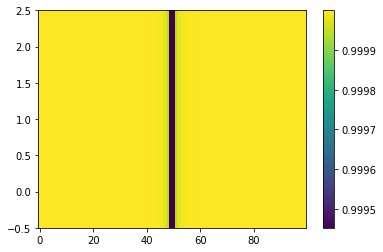

In [101]:
plt.imshow(np.abs(effic_b_copy1[:,:,1,1]),aspect='auto',origin='lower')
plt.colorbar()


In [88]:
delovals=np.linspace(-500e6,500e6,100)*2*pi/2
delmvals=np.linspace(-25e6,25e6,3)*2*pi/2.355*3
ainvals=[0,100]
binvals=[0,100]

aoutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_a=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
boutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, ainval in enumerate(ainvals):
            for ll, binval in enumerate(binvals):
                if (ainval+binval) ==0:
                    print('zero lol')
                else:
                    aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                    effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                    effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                    elapsed_time=time.time()-start_time
                    print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                    print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))
aoutvals_copy2=aoutvals[:]                    
boutvals_copy2=boutvals[:]
effic_a_copy2=effic_a[:]
effic_b_copy2=effic_b[:]                    
                    

zero lol
zero lol


/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in cdouble_scalars


    0, 0, 1, 0, Time: 22.02905559539795
    aout = (-99.98688088673849-0.6797468010941755j), bout = (4.276196676994721e-18-2.4677468889858583e-15j)
    0, 0, 1, 1, Time: 46.78956484794617
    aout = (-99.98688088673849-0.6797468010941757j), bout = (-99.99751569824512-0.21977191745283342j)
zero lol
zero lol
    0, 1, 1, 0, Time: 69.19243454933167
    aout = (-99.98688088673849-0.6797468010941564j), bout = (1.782184222410006e-12+4.571341780482135e-11j)
    0, 1, 1, 1, Time: 94.02265572547913
    aout = (-99.98688088673846-0.6797468010967938j), bout = (-80.55555514319796-8.117511762680865e-11j)
zero lol
zero lol
    0, 2, 1, 0, Time: 116.06454825401306
    aout = (-99.98688088673849-0.6797468010941434j), bout = (1.398732980336416e-16+4.208876812803482e-15j)
    0, 2, 1, 1, Time: 140.83183574676514
    aout = (-99.98688088673849-0.6797468010941431j), bout = (-99.99751569824512+0.2197719174528352j)
zero lol
zero lol
    1, 0, 1, 0, Time: 162.92171812057495
    aout = (-99.98633452710807-0.6

    9, 0, 1, 0, Time: 1286.0349128246307
    aout = (-99.98040591519356-0.8306489083855346j), bout = (-1.8452903846585304e-17-5.1467420258078844e-15j)
    9, 0, 1, 1, Time: 1310.525954246521
    aout = (-99.98040591519356-0.8306489083855351j), bout = (-99.99751569824512-0.21977191745283609j)
zero lol
zero lol
    9, 1, 1, 0, Time: 1332.4395744800568
    aout = (-99.98040591519356-0.8306489083854681j), bout = (3.2509899164103518e-12+6.82722515758818e-11j)
    9, 1, 1, 1, Time: 1356.744235277176
    aout = (-99.9804059151935-0.8306489083894073j), bout = (-80.55555514313889-8.683492144239143e-11j)
zero lol
zero lol
    9, 2, 1, 0, Time: 1378.9171617031097
    aout = (-99.98040591519356-0.8306489083854262j), bout = (2.688021815472895e-16+7.117538070464073e-15j)
    9, 2, 1, 1, Time: 1403.6179158687592
    aout = (-99.98040591519356-0.8306489083854258j), bout = (-99.99751569824512+0.21977191745283803j)
zero lol
zero lol
    10, 0, 1, 0, Time: 1425.760686159134
    aout = (-99.97940183868637

    17, 2, 1, 1, Time: 2526.4633078575134
    aout = (-99.96958171037056-1.034798150299181j), bout = (-99.99751569824512+0.2197719174528437j)
zero lol
zero lol
    18, 0, 1, 0, Time: 2548.6729984283447
    aout = (-99.96762153753205-1.06758943598323j), bout = (-1.3911142353013238e-16-1.2594608354474545e-14j)
    18, 0, 1, 1, Time: 2573.458818912506
    aout = (-99.96762153753205-1.0675894359832308j), bout = (-99.99751569824512-0.21977191745284338j)
zero lol
zero lol
    18, 1, 1, 0, Time: 2595.9131870269775
    aout = (-99.96762153753205-1.067589435982905j), bout = (6.897406245665863e-12+1.1280703181249638e-10j)
    18, 1, 1, 1, Time: 2620.475562095642
    aout = (-99.96762153753191-1.0675894359894171j), bout = (-80.55555514302199-8.667003054193738e-11j)
zero lol
zero lol
    18, 2, 1, 0, Time: 2642.655996799469
    aout = (-99.96762153753204-1.0675894359827274j), bout = (6.169620807909116e-16+1.3779984486032134e-14j)
    18, 2, 1, 1, Time: 2667.296135187149
    aout = (-99.96762153753

    26, 2, 1, 0, Time: 3767.294889688492
    aout = (-99.94186686598569-1.4299771279182496j), bout = (1.6474581313829583e-15+2.975872867590061e-14j)
    26, 2, 1, 1, Time: 3791.8554787635803
    aout = (-99.94186686598569-1.429977127918248j), bout = (-99.99751569824512+0.21977191745286065j)
zero lol
zero lol
    27, 0, 1, 0, Time: 3814.089107275009
    aout = (-99.93659415133554-1.4933077874594358j), bout = (-9.617573508801749e-16-4.101902647858379e-14j)
    27, 0, 1, 1, Time: 3838.728414297104
    aout = (-99.93659415133554-1.4933077874594383j), bout = (-99.99751569824512-0.21977191745287167j)
zero lol
zero lol
    27, 1, 1, 0, Time: 3860.8348581790924
    aout = (-99.93659415133554-1.4933077874566243j), bout = (1.8846373495109096e-11+2.2085876919657506e-10j)
    27, 1, 1, 1, Time: 3885.6246008872986
    aout = (-99.93659415133519-1.4933077874693894j), bout = (-80.55555514273779-5.858935694990064e-11j)
zero lol
zero lol
    27, 2, 1, 0, Time: 3907.9039103984833
    aout = (-99.9365941

    35, 1, 1, 1, Time: 5010.001748323441
    aout = (-99.84771419397617-2.3113457754891127j), bout = (-80.55555514192702+9.571910940419897e-11j)
zero lol
zero lol
    35, 2, 1, 0, Time: 5032.051739931107
    aout = (-99.84771419397751-2.3113457754445603j), bout = (8.447481372839213e-15+1.0431707179664133e-13j)
    35, 2, 1, 1, Time: 5056.802573919296
    aout = (-99.84771419397751-2.311345775444555j), bout = (-99.99751569824512+0.21977191745293512j)
zero lol
zero lol
    36, 0, 1, 0, Time: 5079.163288116455
    aout = (-99.8244343301346-2.480909135240374j), bout = (-1.2373377762151947e-14-2.4585488133085625e-13j)
    36, 0, 1, 1, Time: 5103.652070760727
    aout = (-99.8244343301346-2.480909135240388j), bout = (-99.99751569824514-0.2197719174530754j)
zero lol
zero lol
    36, 1, 1, 0, Time: 5125.979920864105
    aout = (-99.82443433013444-2.48090913515549j), bout = (8.594734368709678e-11+6.110704922159819e-10j)
    36, 1, 1, 1, Time: 5150.511280059814
    aout = (-99.82443433013283-2.4

    44, 1, 1, 0, Time: 6249.924010515213
    aout = (-98.96809045486829-5.940757300678708j), bout = (1.146484190056447e-09+3.5735722376504573e-09j)
    44, 1, 1, 1, Time: 6274.486435890198
    aout = (-98.96809045484225-5.9407573008916j), bout = (-80.55555513463116+2.411478119273749e-09j)
zero lol
zero lol
    44, 2, 1, 0, Time: 6296.906965494156
    aout = (-98.96809045486428-5.940757298612146j), bout = (2.1452492482650919e-13+1.127335234967015e-12j)
    44, 2, 1, 1, Time: 6321.708922147751
    aout = (-98.96809045486428-5.940757298612081j), bout = (-99.99751569824488+0.21977191745395758j)
zero lol
zero lol
    45, 0, 1, 0, Time: 6343.827520847321
    aout = (-98.48048260896105-7.1574064495614165j), bout = (6.930159094755266e-13+3.1986422886725712e-12j)
    45, 0, 1, 1, Time: 6368.424969911575
    aout = (-98.4804826089611-7.157406449561233j), bout = (-99.99751569824443-0.2197719174496241j)
zero lol
zero lol
    45, 1, 1, 0, Time: 6390.672460317612
    aout = (-98.48048260892075-7.157

    53, 1, 1, 0, Time: 7543.255601644516
    aout = (-97.55695286053506+8.950295657198051j), bout = (-3.877689701900988e-09+8.407690548788326e-09j)
    53, 1, 1, 1, Time: 7568.10026550293
    aout = (-97.55695286064224+8.950295656682037j), bout = (-80.555555132944+1.026237710621227e-08j)
zero lol
zero lol
    53, 2, 1, 0, Time: 7590.170581102371
    aout = (-97.55695286057077+8.950295662622375j), bout = (-1.5346508918761904e-12+5.638388156093795e-12j)
    53, 2, 1, 1, Time: 7614.6956305503845
    aout = (-97.55695286057068+8.9502956626227j), bout = (-99.99751569824664+0.2197719174584635j)
zero lol
zero lol
    54, 0, 1, 0, Time: 7637.02379155159
    aout = (-98.48048260890651+7.1574064340000385j), bout = (-4.0905280427215876e-13+1.7815255710369006e-12j)
    54, 0, 1, 1, Time: 7661.68784737587
    aout = (-98.48048260890651+7.157406434000141j), bout = (-99.99751569824552-0.21977191745104863j)
zero lol
zero lol
    54, 1, 1, 0, Time: 7683.5825753211975
    aout = (-98.48048260892077+7.15

    62, 1, 1, 0, Time: 8805.128707408905
    aout = (-99.79538985837515+2.6771620549200534j), bout = (-1.0785464649481153e-10+7.120238723399741e-10j)
    62, 1, 1, 1, Time: 8829.70834326744
    aout = (-99.7953898583772+2.6771620548786887j), bout = (-80.55555514167027+1.2164535450560463e-09j)
zero lol
zero lol
    62, 2, 1, 0, Time: 8852.103792190552
    aout = (-99.79538985837539+2.677162055064161j), bout = (1.7740264051078184e-14-3.202207435156924e-13j)
    62, 2, 1, 1, Time: 8876.888458967209
    aout = (-99.79538985837542+2.677162055064142j), bout = (-99.9975156982451+0.21977191745250893j)
zero lol
zero lol
    63, 0, 1, 0, Time: 8899.193018198013
    aout = (-99.82443433013448+2.4809091351351027j), bout = (-1.0761699251295672e-14+1.2525289793007551e-13j)
    63, 0, 1, 1, Time: 8923.802999973297
    aout = (-99.82443433013448+2.48090913513511j), bout = (-99.99751569824512-0.21977191745270533j)
zero lol
zero lol
    63, 1, 1, 0, Time: 8946.142154455185
    aout = (-99.82443433013444

    71, 1, 1, 0, Time: 10067.155973911285
    aout = (-99.93057065812323+1.5624963103764622j), bout = (-2.158261236479365e-11+2.4182997267798426e-10j)
    71, 1, 1, 1, Time: 10091.64182806015
    aout = (-99.93057065812361+1.562496310362482j), bout = (-80.5555551427258+5.343120108471791e-10j)
zero lol
zero lol
    71, 2, 1, 0, Time: 10114.024442434311
    aout = (-99.93057065812323+1.5624963103802427j), bout = (1.2218408766341062e-15-4.810332483267488e-14j)
    71, 2, 1, 1, Time: 10138.848767757416
    aout = (-99.93057065812323+1.56249631038024j), bout = (-99.99751569824512+0.2197719174527825j)
zero lol
zero lol
    72, 0, 1, 0, Time: 10161.08694076538
    aout = (-99.93659415133554+1.4933077874554217j), bout = (-1.907724170259709e-15+3.3349966119884496e-14j)
    72, 0, 1, 1, Time: 10185.811434745789
    aout = (-99.93659415133554+1.4933077874554237j), bout = (-99.99751569824512-0.2197719174527975j)
zero lol
zero lol
    72, 1, 1, 0, Time: 10208.034700393677
    aout = (-99.9365941513

    80, 0, 1, 1, Time: 11305.011949777603
    aout = (-99.96546566865244+1.1025248401298713j), bout = (-99.99751569824512-0.21977191745281582j)
zero lol
zero lol
    80, 1, 1, 0, Time: 11326.793927907944
    aout = (-99.96546566865244+1.102524840130084j), bout = (-7.59607925660965e-12+1.203162794095403e-10j)
    80, 1, 1, 1, Time: 11351.193992614746
    aout = (-99.96546566865258+1.1025248401231378j), bout = (-80.55555514301746+3.2634287006578893e-10j)
zero lol
zero lol
    80, 2, 1, 0, Time: 11373.254951953888
    aout = (-99.96546566865244+1.1025248401304826j), bout = (1.7070968151617503e-16-1.4111035470921177e-14j)
    80, 2, 1, 1, Time: 11397.499191045761
    aout = (-99.96546566865244+1.1025248401304817j), bout = (-99.99751569824512+0.21977191745281674j)
zero lol
zero lol
    81, 0, 1, 0, Time: 11419.891792297363
    aout = (-99.96762153753203+1.0675894359827272j), bout = (-6.16962080791089e-16+1.377998448603214e-14j)
    81, 0, 1, 1, Time: 11444.454014778137
    aout = (-99.96762

    89, 0, 1, 0, Time: 12541.172488212585
    aout = (-99.97940183868639+0.8516537100011017j), bout = (-2.917907549488677e-16+7.600341637070913e-15j)
    89, 0, 1, 1, Time: 12565.81754207611
    aout = (-99.97940183868639+0.851653710001102j), bout = (-99.99751569824512-0.2197719174528233j)
zero lol
zero lol
    89, 1, 1, 0, Time: 12587.621992111206
    aout = (-99.97940183868639+0.85165371000115j), bout = (-3.5037198413801522e-12+7.177027411388017e-11j)
    89, 1, 1, 1, Time: 12612.09731221199
    aout = (-99.97940183868646+0.8516537099970085j), bout = (-80.55555514313673+2.308075738793365e-10j)
zero lol
zero lol
    89, 2, 1, 0, Time: 12634.315772533417
    aout = (-99.97940183868639+0.8516537100012279j), bout = (2.4093824526725472e-17-5.6315426681892766e-15j)
    89, 2, 1, 1, Time: 12659.04211306572
    aout = (-99.97940183868639+0.8516537100012275j), bout = (-99.99751569824512+0.2197719174528252j)
zero lol
zero lol
    90, 0, 1, 0, Time: 12681.225497722626
    aout = (-99.9804059151

    97, 2, 1, 1, Time: 13778.74843120575
    aout = (-99.98575331716631+0.708345040641827j), bout = (-99.99751569824512+0.21977191745282804j)
zero lol
zero lol
    98, 0, 1, 0, Time: 13800.85268998146
    aout = (-99.98633452710807+0.6937514368957989j), bout = (-1.4941237789331275e-16+4.439261368085287e-15j)
    98, 0, 1, 1, Time: 13825.344420194626
    aout = (-99.98633452710807+0.6937514368957991j), bout = (-99.99751569824512-0.21977191745282657j)
zero lol
zero lol
    98, 1, 1, 0, Time: 13847.169556856155
    aout = (-99.98633452710807+0.6937514368958135j), bout = (-1.8945682444176657e-12+4.761701748270097e-11j)
    98, 1, 1, 1, Time: 13871.49513053894
    aout = (-99.9863345271081+0.6937514368930667j), bout = (-80.55555514319677+1.7712330606651149e-10j)
zero lol
zero lol
    98, 2, 1, 0, Time: 13893.635169267654
    aout = (-99.98633452710807+0.6937514368958352j), bout = (-3.209363146866643e-18-2.662576193958458e-15j)
    98, 2, 1, 1, Time: 13918.127889156342
    aout = (-99.986334

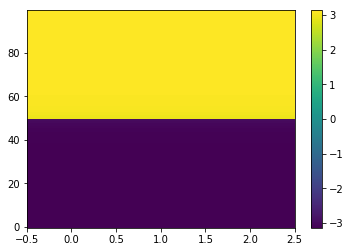

In [112]:
plt.imshow(np.angle(aoutvals_copy2[:,:,1,1]),aspect='auto',origin='lower')
plt.colorbar()

In [113]:
p

{'deltamu': 0.0,
 'deltao': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'go': 51.9,
 'No': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'mean_delam': 0,
 'sd_delam': 66700480.96793615,
 'mean_delao': 0,
 'sd_delao': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nm': 2.22e+16,
 'gm': 1.04,
 'gammaoc': 10681415.022205297,
 'gammaoi': 49951323.19207771,
 'gammamc': 439822.971502571,
 'gammami': 4084070.449666731,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqmu': 5186000000.0,
 'freq_pump': 195113360000000.0,
 'freqo': 195118546000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'Omega': -492090.88755145477}

In [131]:
avals=np.linspace(0,50000,5)
bvals=np.linspace(0,50000,5)
S13vals=np.zeros((len(avals),len(bvals)),dtype=np.complex_)
S12vals=np.zeros((len(avals),len(bvals)),dtype=np.complex_)
for ii, aval in enumerate(avals):
    print('     ' + str(ii))
    for jj, bval in enumerate(bvals):
        #print('     ' + str(ii))
        S13vals[ii,jj]=S13(aval,bval,0,0)
        S12vals[ii,jj]=S12(aval,bval,0,0)

     0
     1
     2
     3
     4


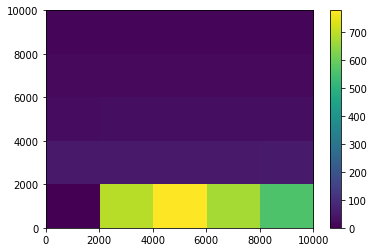

In [132]:
plt.imshow(abs(S13vals),extent=(0,10000,0,10000),aspect='auto',origin='lower')
plt.colorbar()

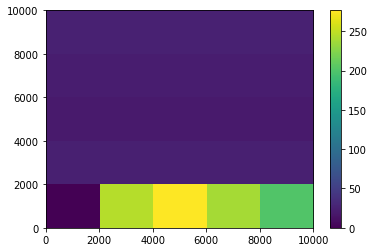

In [133]:
plt.imshow(abs(S12vals),extent=(0,10000,0,10000),aspect='auto',origin='lower')
plt.colorbar()

In [130]:
S12vals/S13vals

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[            nan       +nanj,  0.00000000e+00+0.35429956j,
         0.00000000e+00+0.3543064j ,  0.00000000e+00+0.35431781j,
         0.00000000e+00+0.35433379j,  0.00000000e+00+0.35435433j,
         0.00000000e+00+0.35437944j,  0.00000000e+00+0.35440912j,
         0.00000000e+00+0.35444337j,  0.00000000e+00+0.3544822j ],
       [ 0.00000000e+00-0.34292363j,  1.34852703e-02-0.34266519j,
         2.69407785e-02-0.34189101j,  4.03369854e-02-0.34060455j,
         5.36447948e-02-0.33881151j,  6.68357657e-02-0.3365198j ,
         7.98823154e-02-0.33373942j,  9.27579082e-02-0.33048239j,
         1.05437230e-01-0.32676257j,  1.17896344e-01-0.32259557j],
       [ 0.00000000e+00-0.34524805j,  6.46661537e-03-0.34519065j,
         1.29301345e-02-0.34501848j,  1.93874667e-02-0.34473173j,
         2.58355320e-02-0.34433068j,  3.22712666e-02-0.34381575j,
         3.86916283e-02-0.34318744j,  4.50936015e-02-0.34244639j,
         5.14742024e-02-0.34159335j,  5.78304844e-02-0.34062915j],
       

In [173]:
S13_test_fun=lambda x: -np.abs(S13(x[0]+1j*x[1],x[2]+1j*x[3],0,0))/(np.abs(x[2]+1j*x[3]))

In [168]:
abd=scipy.optimize.minimize(S13_test_fun,[5000,1000])
abd

      fun: -807.5229545283019
 hess_inv: array([[532.15413798,  10.22641883],
       [ 10.22641883,   1.16584018]])
      jac: array([1.52587891e-05, 2.28881836e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 213
      nit: 4
     njev: 51
   status: 2
  success: False
        x: array([-422.32145773,  918.39501671])

In [160]:
test_sq([2,45])

In [155]:
2^6

In [169]:
abc=scipy.optimize.minimize(S13_test_fun,[5000,0,1000,0])


In [170]:
abc

      fun: -807.5558648953393
 hess_inv: array([[ 2.23462247e+02, -2.44226849e-02,  0.00000000e+00,
         0.00000000e+00],
       [-2.44226849e-02,  1.00000236e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 114
      nit: 3
     njev: 19
   status: 0
  success: True
        x: array([-4.22702545e+02,  8.00306522e-01,  1.00000000e+03,  0.00000000e+00])

In [172]:
S13(-4.22e2,1000,0,0)

(37.45017101963784-806.647810069799j)

In [174]:
abe=scipy.optimize.minimize(S13_test_fun,[5000,0,1000,0])
abe

      fun: -1249750.0932632086
 hess_inv: array([[ 1.04325029e+00, -2.46063724e-01, -9.37116178e-06,
         1.14323722e-04],
       [-2.46063723e-01,  2.20997604e-01, -3.83358095e-06,
         4.69393637e-05],
       [-9.37115708e-06, -3.83358447e-06,  3.08265054e-10,
        -3.76789368e-09],
       [ 1.14323723e-04,  4.69393634e-05, -3.76789699e-09,
         4.60442601e-08]])
      jac: array([ 2.55812500e+02, -6.25000000e-02,  1.10492791e+10,  9.03706461e+08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 588
      nit: 8
     njev: 96
   status: 2
  success: False
        x: array([ 4.80949918e+03, -1.28212323e+00,  1.12341975e-04,  9.17979839e-06])

In [29]:
p

{'deltamu': 0.0,
 'deltao': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'go': 51.9,
 'No': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'mean_delam': 0,
 'sd_delam': 66700480.96793615,
 'mean_delao': 0,
 'sd_delao': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nm': 2.22e+16,
 'gm': 1.04,
 'gammaoc': 10681415.022205297,
 'gammaoi': 49951323.19207771,
 'gammamc': 439822.971502571,
 'gammami': 4084070.449666731,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqmu': 5186000000.0,
 'freq_pump': 195113360000000.0,
 'freqo': 195118546000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'Omega': -492090.88755145477}

In [313]:
(1.055e-34*p['freqmu']*2*pi/(1.38e-23*5))**-1
p['T']=5
nbathmu=1.0/(np.exp(1.055e-34*p['freqmu']*2.0*pi/(1.38e-23*p['T']))-1.0)
nbatho=1.0/(np.exp(1.055e-34*p['freqo']*2.0*pi/(1.38e-23*p['T']))-1.0)
1.0/(np.exp(1.055e-34*195118546000000.0*2.0*pi/(1.38e-23*5))-1.0)-(1.055e-34*195118546000000.0*2.0*pi/(1.38e-23*5))**-1

In [102]:
p['mean_delam']=0
p['sd_delam']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*170e6/2.355 
sd_delao_vals=np.linspace(150e6,10e6,5)*2*pi/2.355
sd_delam_vals=np.linspace(25e6,1e6,5)*2*pi/2.355
S13_vals=np.zeros((len(sd_delao_vals),len(sd_delam_vals)),dtype=np.complex_)
for ii, sd_delao_val in enumerate(sd_delao_vals):
    for jj, sd_delam_val in enumerate(sd_delam_vals):
        print('    ' + str(ii) + ', ' + str(jj))
        p['sd_delao']=sd_delao_val
        p['sd_delam']=sd_delam_val
        S13_vals[ii,jj]=S13(10000,20000, 100e6,20e6,p)
        

    0, 0
    0, 1
    0, 2
    0, 3
    0, 4
    1, 0
    1, 1
    1, 2
    1, 3
    1, 4
    2, 0
    2, 1
    2, 2
    2, 3
    2, 4
    3, 0
    3, 1
    3, 2
    3, 3
    3, 4
    4, 0
    4, 1
    4, 2
    4, 3
    4, 4


In [120]:
2000*np.sqrt(p['gammaoc'])*1e-6,10000*np.sqrt(p['gammamc'])*1e-6

In [103]:
p['sd_delam']*1e-8

In [105]:
sig13I=coh13_Ifun(0,0,10000,20000, 100e6,20e6,p)
sig13R=coh13_Rfun(0,0,10000,20000, 100e6,20e6,p)
(sig13R+1j*sig13I)*p['No']*p['go']

(68521500382879.35+343114617471.9498j)

In [106]:
S13_vals

array([[   3185.67621842  +15.95195772j,    4191.6792347   +20.98941805j,
           6126.30041967  +30.67684177j,   11377.41506283  +56.97127756j,
          79641.90436125 +398.79893752j],
       [   4155.22985011  +20.80690138j,    5467.40769743  +27.37750181j,
           7990.82663435  +40.01327187j,   14840.10660368  +74.31036204j,
         103880.74481898 +520.1725272j ],
       [   5973.14290953  +29.90992073j,    7859.39856504  +39.35515885j,
          11486.81328687  +57.51907832j,   21332.65324277 +106.82114543j,
         149328.57067711 +747.74800785j],
       [  10618.920728    +53.1731924j ,   13972.26411557  +69.96472684j,
          20421.00139879 +102.25613923j,   37924.71687586 +189.90425853j,
         265473.01453585+1329.32979173j],
       [  47785.14326973 +239.27936578j,   62875.18851179 +314.84127076j,
          91894.50628246 +460.15262648j,  170661.22591895 +854.56916329j,
        1194628.56525431+5981.98406199j]])

In [107]:
gh={}
gh['hon']=1
test_fun = lambda x, y=gh['hon']: x+y

In [108]:
test_fun(1)

In [109]:
gh['hon']=4

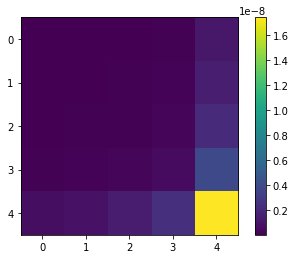

In [111]:
plt.imshow((np.abs(S13_vals)/np.abs((sig13R+1j*sig13I)*p['No']*p['go'])))
plt.colorbar()

In [148]:
p['Nm']=5e19
p['No']=1.18e19

In [149]:

delovals=np.linspace(-100e6,100e6,50)*2*pi/2
delmvals=[0]
ainvals=[0,600000]
binvals=[0,600000]

aoutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_a=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
boutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, ainval in enumerate(ainvals):
            for ll, binval in enumerate(binvals):
                if (ainval+binval) ==0:
                    print('zero lol')
                else:
                    aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                    effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                    effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                    elapsed_time=time.time()-start_time
                    print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                    print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))
aoutvals_copy3=aoutvals[:]                    
boutvals_copy3=boutvals[:]
effic_a_copy3=effic_a[:]
effic_b_copy3=effic_b[:]

zero lol
zero lol


/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in cdouble_scalars


    0, 0, 1, 0, Time: 52.64274263381958
    aout = (-598049.5627448091-20211.655800390898j), bout = (0.0028884725818893167+0.015273959840169967j)
    0, 0, 1, 1, Time: 108.20298171043396
    aout = (-598049.5625119229-20211.65944798364j), bout = (-483327.72341178014+0.006646594781177146j)
zero lol
zero lol
    1, 0, 1, 0, Time: 161.13327407836914
    aout = (-597881.7349578767-21054.831202734356j), bout = (0.003261484085978075+0.016585265675524704j)
    1, 0, 1, 1, Time: 216.73211932182312
    aout = (-597881.7346932098-21054.835167229365j), bout = (-483327.72010483575+0.007586084884945928j)
zero lol
zero lol
    2, 0, 1, 0, Time: 269.3725664615631
    aout = (-597691.3624491231-21970.585268873965j), bout = (0.003701074864038075+0.018072190284867444j)
    2, 0, 1, 1, Time: 324.6765949726105
    aout = (-597691.3621466011-21970.589593380806j), bout = (-483327.71637738525+0.008667555330732652j)
zero lol
zero lol
    3, 0, 1, 0, Time: 377.79289865493774
    aout = (-597474.2366469781-2296

    27, 0, 1, 0, Time: 2919.2984204292297
    aout = (-500195.35992075654+105524.02235898517j), bout = (-0.9074851697340413+0.7405268275318544j)
    27, 0, 1, 1, Time: 2973.2485411167145
    aout = (-500195.5352282645+105523.8119746889j), bout = (-483328.23920901795+0.8307465787804021j)
zero lol
zero lol
    28, 0, 1, 0, Time: 3025.0970208644867
    aout = (-533762.5916553064+98048.82670205436j), bout = (-0.457903278494539+0.5008984457601681j)
    28, 0, 1, 1, Time: 3079.3266792297363
    aout = (-533762.6718085335+98048.69018334146j), bout = (-483327.8310314864+0.5649146172392547j)
zero lol
zero lol
    29, 0, 1, 0, Time: 3133.696459531784
    aout = (-554269.8003387097+87034.79506601852j), bout = (-0.2616316147548166+0.34900584566598997j)
    29, 0, 1, 1, Time: 3188.3498702049255
    aout = (-554269.8416810884+87034.70227627222j), bout = (-483327.679605394+0.3984367689986646j)
zero lol
zero lol
    30, 0, 1, 0, Time: 3240.381446838379
    aout = (-567029.4648031301+76695.63477515703j

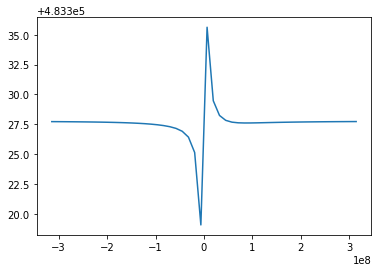

In [158]:
plt.plot(np.linspace(-100e6,100e6,50)*2*pi/2, np.abs(boutvals_copy3[:,0,1,1]))


In [159]:
delovals=[0]
delmvals=np.linspace(-200e6,200e6,50)*2*pi/2.355*3
ainvals=[0,600000]
binvals=[0,600000]

aoutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_a=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
boutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, ainval in enumerate(ainvals):
            for ll, binval in enumerate(binvals):
                if (ainval+binval) ==0:
                    print('zero lol')
                else:
                    aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                    effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                    effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                    elapsed_time=time.time()-start_time
                    print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                    print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))
aoutvals_copy4=aoutvals[:]                    
boutvals_copy4=boutvals[:]
effic_a_copy4=effic_a[:]
effic_b_copy4=effic_b[:]

zero lol
zero lol


KeyboardInterrupt: 

In [173]:
effic_a_copy4.shape

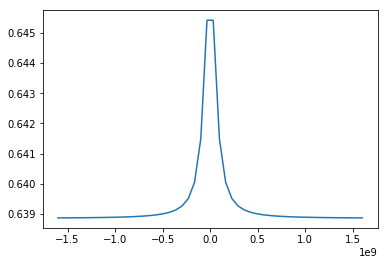

In [174]:
plt.plot(np.linspace(-200e6,200e6,50)*2*pi/2.355*3, np.abs(effic_a_copy4[0,:,1,1]))
#plt.plot(np.linspace(-200e6,200e6,50)*2*pi/2.355*3, np.abs(aoutvals_copy4[0,:,1,0]))

In [162]:
aoutvals_copy4.shape

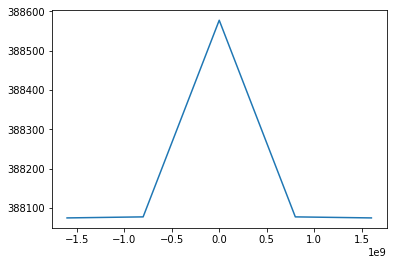

In [147]:
plt.plot(delmvals,np.abs(aoutvals_copy4[0,:,0,0]))

In [183]:
start_time=time.time()
S13_test=S13(2000,10000,5e6,-1e6,p)
S12_test=S12(2000,10000,5e6,-1e6,p)

elapsed_time=time.time()-start_time
S13_test,S12_test, elapsed_time

((10112323.26858092+969103.6367037713j),
 (14202.834875834598+38248.02493822836j),
 2.778433322906494)

In [187]:
delovals=np.linspace(-100e6,100e6,11)*2*pi/2
delmvals=np.linspace(-200e6,200e6,11)*2*pi/2.355*3
avals=[0,2000,10000]
bvals=[0,2000,10000]

S13vals=np.zeros((len(delovals),len(delmvals),len(avals),len(bvals)), dtype=np.complex_)
S12vals=np.zeros((len(delovals),len(delmvals),len(avals),len(bvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, aval in enumerate(avals):
            for ll, bval in enumerate(bvals):
                if (ainval+binval) ==0:
                    print('zero lol')
                else:
                    S13vals[ii,jj,kk,ll]= S13(aval,bval,deloval,delmval,p)
                    S12vals[ii,jj,kk,ll]= S12(aval,bval,deloval,delmval,p)
                    elapsed_time=time.time()-start_time
                    print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                    print('    '+ 'S13 = ' +str(S13vals[ii,jj,kk,ll]) + ', S12 = '+str(S12vals[ii,jj,kk,ll]))


zero lol
zero lol
zero lol
    0, 0, 1, 0, Time: 2.8542137145996094
    S13 = (-458.2337669462692+0.7300630407289381j), S12 = (-0.06033692877303086+0.0001057295552277285j)
    0, 0, 1, 1, Time: 5.8111889362335205
    S13 = (-458.23723888983903+0.7300660142300387j), S12 = (-0.0903002483304198+0.00011510694893193516j)
    0, 0, 1, 2, Time: 8.78204083442688
    S13 = (-458.2511261850906+0.7300779073923762j), S12 = (-0.21015350366806612+0.0001526165165026942j)
    0, 0, 2, 0, Time: 11.717092990875244
    S13 = (-2194.102403795657+3.4956679061554023j), S12 = (-0.2889251095183097+0.0005062748523342261j)
    0, 0, 2, 1, Time: 14.670940160751343
    S13 = (-2194.105576792509+3.495670510429267j), S12 = (-0.3173939574260117+0.000515184823047962j)
    0, 0, 2, 2, Time: 17.58632755279541
    S13 = (-2194.118266607629+3.4956809236678477j), S12 = (-0.43126926554990297+0.0005508246793958386j)
zero lol
zero lol
zero lol
    0, 1, 1, 0, Time: 20.535538911819458
    S13 = (-456.6268912003881+0.727503140

    0, 9, 1, 2, Time: 167.67542624473572
    S13 = (-458.9493680212351+0.7311941357261806j), S12 = (0.23703294063177954-1.2134677883048044e-05j)
    0, 9, 2, 0, Time: 170.62308192253113
    S13 = (-2197.4503759070244+3.5009978040235064j), S12 = (0.23838780673647833-0.0004088309531202166j)
    0, 9, 2, 1, Time: 173.53352451324463
    S13 = (-2197.4479587749674+3.500992391755545j), S12 = (0.2739657341916682-0.00039491163229177066j)
    0, 9, 2, 2, Time: 176.46480441093445
    S13 = (-2197.438287874401+3.5009707397251604j), S12 = (0.41627754380960563-0.0003392343096167142j)
zero lol
zero lol
zero lol
    0, 10, 1, 0, Time: 179.39947533607483
    S13 = (-459.3820584728105+0.7318917215543111j), S12 = (0.04141080970636183-6.923826688658431e-05j)
    0, 10, 1, 1, Time: 182.34267926216125
    S13 = (-459.3796823276207+0.731886801141219j), S12 = (0.07136637999023676-5.98630802105337e-05j)
    0, 10, 1, 2, Time: 185.30193948745728
    S13 = (-459.37017743143144+0.7318671191252485j), S12 = (0.191

    1, 8, 1, 0, Time: 338.3470678329468
    S13 = (-571.8657745242505+1.1388767556564108j), S12 = (0.08171802900253572-0.000176765873309469j)
    1, 8, 1, 1, Time: 341.402446269989
    S13 = (-571.8611003364597+1.1388639353308816j), S12 = (0.1315974157543213-0.0001507471151577004j)
    1, 8, 1, 2, Time: 344.3739230632782
    S13 = (-571.8424024178546+1.138812652158054j), S12 = (0.33111500143721107-4.667206210630292e-05j)
    1, 8, 2, 0, Time: 347.5009286403656
    S13 = (-2674.737304093572+5.326767711178005j), S12 = (0.3821547978409672-0.0008268493684992692j)
    1, 8, 2, 1, Time: 350.5670266151428
    S13 = (-2674.73371807213+5.326757280966727j), S12 = (0.42824450248964174-0.0008028053636638114j)
    1, 8, 2, 2, Time: 353.6127471923828
    S13 = (-2674.719368883084+5.326715552087592j), S12 = (0.6126035869868393-0.0007066292044794957j)
zero lol
zero lol
zero lol
    1, 9, 1, 0, Time: 356.6336929798126
    S13 = (-572.966096419669+1.1410682959724867j), S12 = (0.06456289844149903-0.00013

    2, 7, 1, 1, Time: 515.8588759899139
    S13 = (-756.3711056122352+2.008416464966353j), S12 = (0.232951955648656-0.00040696037526964066j)
    2, 7, 1, 2, Time: 518.6562616825104
    S13 = (-756.3351218312004+2.0082813111002826j), S12 = (0.531609499295261-0.00017325941992270646j)
    2, 7, 2, 0, Time: 521.4869215488434
    S13 = (-3371.5396163418222+8.952601452459325j), S12 = (0.7053491913531474-0.002074865179855076j)
    2, 7, 2, 1, Time: 524.2995841503143
    S13 = (-3371.534096635433+8.952577950406095j), S12 = (0.7704769501417028-0.0020238952573794974j)
    2, 7, 2, 2, Time: 527.1110446453094
    S13 = (-3371.5120035768637+8.952483911532136j), S12 = (1.030988941723973-0.0018200148127696207j)
zero lol
zero lol
zero lol
    2, 8, 1, 0, Time: 529.9358911514282
    S13 = (-760.346340940599+2.0189831114239354j), S12 = (0.11423883637174614-0.0003183273443539876j)
    2, 8, 1, 1, Time: 532.8136975765228
    S13 = (-760.3398417938405+2.0189606385162366j), S12 = (0.16398972644066429-0.0002

    3, 6, 1, 0, Time: 682.7332005500793
    S13 = (-1098.3104427522003+4.374574886161996j), S12 = (0.42950970623977985-0.00201747407419466j)
    3, 6, 1, 1, Time: 685.5706210136414
    S13 = (-1098.286508851443+4.374430358549541j), S12 = (0.5781321849924591-0.0017848354467638822j)
    3, 6, 1, 2, Time: 688.3677406311035
    S13 = (-1098.190750129518+4.373852165932301j), S12 = (1.1726236199776803-0.000854278524488653j)
    3, 6, 2, 0, Time: 691.1737408638
    S13 = (-4340.580927398239+17.28855112825437j), S12 = (1.695920917216238-0.007978984111921201j)
    3, 6, 2, 1, Time: 693.9761242866516
    S13 = (-4340.574356295061+17.2884858721682j), S12 = (1.8078646780557646-0.007803716803052131j)
    3, 6, 2, 2, Time: 696.7887337207794
    S13 = (-4340.548001693264+17.288224608119194j), S12 = (2.2556460258416506-0.007102637612817715j)
zero lol
zero lol
zero lol
    3, 7, 1, 0, Time: 699.6192750930786
    S13 = (-1125.3362027957728+4.482229943967972j), S12 = (0.2536313475092057-0.001060018130916

    4, 4, 2, 0, Time: 846.9652016162872
    S13 = (-5068.612794032496+40.3774790713849j), S12 = (-3.3396127864382774+0.029252271811999055j)
    4, 4, 2, 1, Time: 849.9183301925659
    S13 = (-5068.630081254698+40.37747449527274j), S12 = (-3.400365751247424+0.029347418878313755j)
    4, 4, 2, 2, Time: 852.8508081436157
    S13 = (-5068.699170369246+40.37745561322389j), S12 = (-3.6433617906015936+0.029727982154177907j)
zero lol
zero lol
zero lol
    4, 5, 1, 0, Time: 855.7972736358643
    S13 = (-826.6348081369952+7.459982234926462j), S12 = (6.408837505320422+38.827190027454j)
    4, 5, 1, 1, Time: 858.7855417728424
    S13 = (-823.662269298131+9.577978176872477j), S12 = (7.102662928522887+133.94335675301863j)
    4, 5, 1, 2, Time: 861.7273602485657
    S13 = (-794.5183724774556+14.320418007206335j), S12 = (8.679630080632137+355.0024155022125j)
    4, 5, 2, 0, Time: 864.6322150230408
    S13 = (-2928.207530229016+26.081277089820045j), S12 = (21.828863377407274+122.25596675800061j)
    4,

    5, 3, 1, 0, Time: 1013.86199259758
    S13 = (0.2987953727001351+395.4587116082105j), S12 = (-0.00042337826323618954+0.10562346120055406j)
    5, 3, 1, 1, Time: 1016.7061724662781
    S13 = (0.2986888828682455+395.45263881212605j), S12 = (0.012699001880920248+0.10561164492914098j)
    5, 3, 1, 2, Time: 1019.5386204719543
    S13 = (0.29815617546768997+395.4283498571059j), S12 = (0.06518855397509281+0.10556438039186533j)
    5, 3, 2, 0, Time: 1022.3915078639984
    S13 = (0.0598552176499349+79.19753271213145j), S12 = (-0.0025229344613853966+0.02115867855965068j)
    5, 3, 2, 1, Time: 1025.2488527297974
    S13 = (0.05976575226553551+79.19728888540044j), S12 = (0.010717544718435239+0.021148326818661647j)
    5, 3, 2, 2, Time: 1028.162734746933
    S13 = (0.05938651551352301+79.19631366763873j), S12 = (0.06367944349143498+0.02110691988726851j)
zero lol
zero lol
zero lol
    5, 4, 1, 0, Time: 1031.0215129852295
    S13 = (0.5972742595561036+395.23531238063947j), S12 = (-0.0016854036662

    6, 1, 1, 2, Time: 1173.3352506160736
    S13 = (2194.834331090322+17.484163923579732j), S12 = (0.10212843607188359+0.0023046811997341557j)
    6, 1, 2, 0, Time: 1176.3108010292053
    S13 = (5328.520363647651+42.44713412304902j), S12 = (0.6795793543248034+0.005426555668156682j)
    6, 1, 2, 1, Time: 1179.1937725543976
    S13 = (5328.519058828149+42.44712921273173j), S12 = (0.6657095842703231+0.0054319908006300694j)
    6, 1, 2, 2, Time: 1182.1393611431122
    S13 = (5328.513836221019+42.44710959232257j), S12 = (0.6102311464149557+0.005453731082010687j)
zero lol
zero lol
zero lol
    6, 2, 1, 0, Time: 1185.0693411827087
    S13 = (2188.415898431284+17.432963000636466j), S12 = (0.36687968128486786+0.002935010003338591j)
    6, 2, 1, 1, Time: 1187.986270904541
    S13 = (2188.4349756043407+17.433134051247592j), S12 = (0.3194162996768652+0.002959798152775921j)
    6, 2, 1, 2, Time: 1190.9225163459778
    S13 = (2188.5112815607504+17.43381825789034j), S12 = (0.12956380774517262+0.00305

    6, 10, 2, 2, Time: 1339.8235256671906
    S13 = (5330.999489747303+42.46713295175226j), S12 = (-0.5365013180449545-0.004719413780338199j)
zero lol
zero lol
zero lol
    7, 0, 1, 0, Time: 1342.8978033065796
    S13 = (1136.8697141683833+4.52817504110055j), S12 = (0.11303846684423681+0.0004532718927795343j)
    7, 0, 1, 1, Time: 1345.8184669017792
    S13 = (1136.8760623637622+4.528203805519211j), S12 = (0.08342057925958313+0.00046254406499592635j)
    7, 0, 1, 2, Time: 1348.7449326515198
    S13 = (1136.9014546288859+4.528318863195245j), S12 = (-0.03505086753347613+0.000499632721478738j)
    7, 0, 2, 0, Time: 1351.6954567432404
    S13 = (4460.449192888319+17.76605925425731j), S12 = (0.44341937452547403+0.0017784613056320642j)
    7, 0, 2, 1, Time: 1354.6504909992218
    S13 = (4460.451699685768+17.76607198038928j), S12 = (0.42131962069515+0.0017853815672449018j)
    7, 0, 2, 2, Time: 1357.5165271759033
    S13 = (4460.461725015017+17.766122885670015j), S12 = (0.332920904282793+0.00

    7, 9, 1, 2, Time: 1508.0687546730042
    S13 = (1133.31030681483+4.514049711487157j), S12 = (0.018150961922520584-0.0006093060071844296j)
    7, 9, 2, 0, Time: 1511.036571264267
    S13 = (4449.599851767821+17.7228962605871j), S12 = (-0.6559282185595134-0.0026768379023856532j)
    7, 9, 2, 1, Time: 1513.972452878952
    S13 = (4449.594978748254+17.72288301150803j), S12 = (-0.6282718321279073-0.0026660137600674795j)
    7, 9, 2, 2, Time: 1516.8968951702118
    S13 = (4449.575480713353+17.722829983274416j), S12 = (-0.5176457965192192-0.0026227169950372533j)
zero lol
zero lol
zero lol
    7, 10, 1, 0, Time: 1519.839991569519
    S13 = (1135.8170054938532+4.523993167317802j), S12 = (-0.13118907903914392-0.000531054151204737j)
    7, 10, 1, 1, Time: 1522.7658243179321
    S13 = (1135.8095865004182+4.523968416864527j), S12 = (-0.10156681067249863-0.0005217810584916334j)
    7, 10, 1, 2, Time: 1525.6861238479614
    S13 = (1135.7799090513024+4.5238694074367665j), S12 = (0.0169223563199305

    8, 7, 2, 2, Time: 1676.5992350578308
    S13 = (3295.9638015959367+8.752117057471548j), S12 = (-0.902258541215536-0.0038173385119332397j)
zero lol
zero lol
zero lol
    8, 8, 1, 0, Time: 1680.0175001621246
    S13 = (755.1295297449351+2.0051366793556746j), S12 = (-0.1657036066593332-0.0004839577544385824j)
    8, 8, 1, 1, Time: 1683.025229692459
    S13 = (755.1200277693479+2.005123151179777j), S12 = (-0.1159160716257152-0.00045798677967692514j)
    8, 8, 1, 2, Time: 1685.9812605381012
    S13 = (755.0820176443602+2.005069031980693j), S12 = (0.08323416667079049-0.0003541028283748996j)
    8, 8, 2, 0, Time: 1688.9244418144226
    S13 = (3366.5623279979395+8.939416805810552j), S12 = (-0.738901928190064-0.002157886485554585j)
    8, 8, 2, 1, Time: 1691.8626391887665
    S13 = (3366.5548445793324+8.939407384900136j), S12 = (-0.6954677045291451-0.0021352278495721517j)
    8, 8, 2, 2, Time: 1694.7804255485535
    S13 = (3366.524902338474+8.939369675889322j), S12 = (-0.5217303085864818-0.

    9, 6, 1, 1, Time: 1845.4703392982483
    S13 = (232.71331164030414+0.46391285529113224j), S12 = (-0.36350027105093763-0.006593077736199617j)
    9, 6, 1, 2, Time: 1848.3620822429657
    S13 = (232.59144518892487+0.46536169029855257j), S12 = (0.2693852046903823-0.005603531094833991j)
    9, 6, 2, 0, Time: 1851.2963531017303
    S13 = (1131.5043187489607+2.2535922879537553j), S12 = (-2.537608893014854-0.033275438275916384j)
    9, 6, 2, 1, Time: 1854.24178981781
    S13 = (1131.4660739704116+2.253927570402494j), S12 = (-2.3844257047842827-0.03303587578085512j)
    9, 6, 2, 2, Time: 1857.2811961174011
    S13 = (1131.313005904266+2.255268509262887j), S12 = (-1.7716905425324803-0.0320776225237653j)
zero lol
zero lol
zero lol
    9, 7, 1, 0, Time: 1860.220563173294
    S13 = (547.4816606196795+1.0903204684751608j), S12 = (-0.2359569238453206-0.0007066194287591543j)
    9, 7, 1, 1, Time: 1863.1285195350647
    S13 = (547.4680390615767+1.0903269140777614j), S12 = (-0.16082524885326133-0.0

    10, 4, 2, 0, Time: 2012.3842570781708
    S13 = (2164.6843063494844+3.44878855356358j), S12 = (0.6112452936091226+0.0017455900856032057j)
    10, 4, 2, 1, Time: 2015.2530438899994
    S13 = (2164.6901884732015+3.4488070231967747j), S12 = (0.46860892991133846+0.0019688040048279425j)
    10, 4, 2, 2, Time: 2018.1590185165405
    S13 = (2164.713673619324+3.448880835698788j), S12 = (-0.10193410354710554+0.002861655877893329j)
zero lol
zero lol
zero lol
    10, 5, 1, 0, Time: 2021.1120629310608
    S13 = (427.60783319667536+0.7152106295815073j), S12 = (0.6845685647436351-7.530883309076605j)
    10, 5, 1, 1, Time: 2024.0237576961517
    S13 = (427.44773324685065+0.28668957344709867j), S12 = (0.5449503295300494+87.50088256166788j)
    10, 5, 1, 2, Time: 2026.9226250648499
    S13 = (424.1265659464984-0.8202006681402689j), S12 = (0.18698642880614744+331.9595640090771j)
    10, 5, 2, 0, Time: 2029.8390805721283
    S13 = (2053.083356524331+3.4323951179779053j), S12 = (3.228590644831563-35.8

In [208]:
S13vals_copy1=S13vals[:]
S12vals_copy1=S12vals[:]

In [189]:
np.sqrt(1/p['gammaoc']*((p['gammaoi']+p['gammaoc'])**2/4))

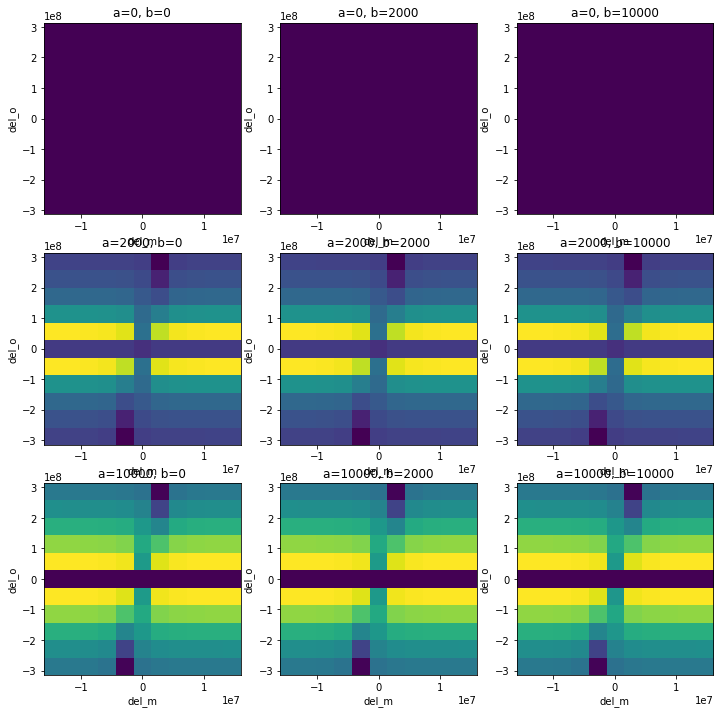

In [249]:
fig =plt.subplots(figsize=(12,12))
pltnum=1
im_lims=[min(delmvals),max(delmvals),min(delovals),max(delovals)]
for ii in range(3):
    for jj in range(3):
        sbplt=plt.subplot(3,3,pltnum)
        pltnum+=1
        sbplt.imshow(np.abs(S13vals[:,:,ii,jj]),extent=im_lims,aspect='auto',origin='lower')
        #sbplt.colorbar()
        plt.title('a=' + str(avals[ii])+ ', b=' + str(bvals[jj]) )
        plt.xlabel('del_m')
        plt.ylabel('del_o')

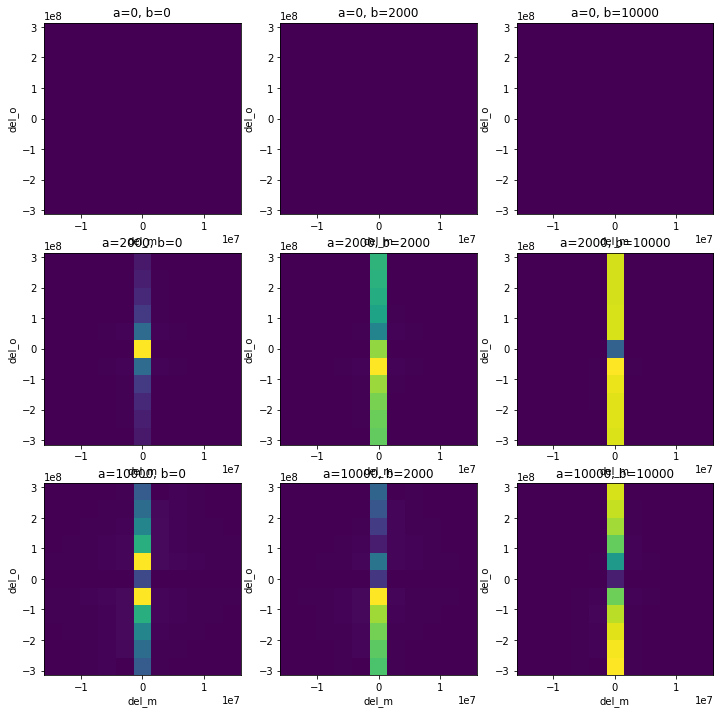

In [248]:
fig =plt.subplots(figsize=(12,12))
pltnum=1
im_lims=[min(delmvals),max(delmvals),min(delovals),max(delovals)]
for ii in range(3):
    for jj in range(3):
        sbplt=plt.subplot(3,3,pltnum)
        pltnum+=1
        sbplt.imshow(np.abs(S12vals[:,:,ii,jj]),extent=im_lims,aspect='auto',origin='lower')
        #sbplt.colorbar()
        plt.title('a=' + str(avals[ii])+ ', b=' + str(bvals[jj]) )
        plt.xlabel('del_m')
        plt.ylabel('del_o')

In [244]:
delmvals=np.linspace(-2e6,2e6,21)*2*pi/2.355*3
S12vals_test=np.zeros(len(delmvals),dtype=np.complex_)

for ii, delmval in enumerate(delmvals):
    S12vals_test[ii]=S12(2000,2000,0,delmval,p)

In [234]:
S12vals_copy1.shape

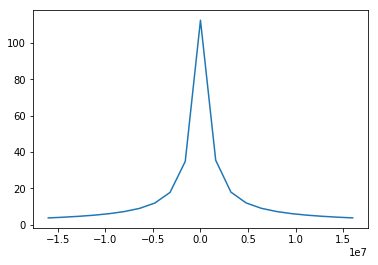

In [245]:
plt.plot(delmvals,np.abs(S12vals_test))

In [ ]:
delovals=np.linspace(-100e6,100e6,51)*2*pi/2
avals=[0,2000,10000]
bvals=[0,2000,10000]

S13vals=np.zeros((len(delovals),len(delmvals),len(avals),len(bvals)), dtype=np.complex_)
S12vals=np.zeros((len(delovals),len(delmvals),len(avals),len(bvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, aval in enumerate(avals):
            for ll, bval in enumerate(bvals):
                if aval==0 & bval ==0:
                    print('zero lol')
                else:
                    S13vals[ii,jj,kk,ll]= S13(aval,bval,deloval,delmval,p)
                    S12vals[ii,jj,kk,ll]= S12(aval,bval,deloval,delmval,p)
                    elapsed_time=time.time()-start_time
                    print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                    print('    '+ 'S13 = ' +str(S13vals[ii,jj,kk,ll]) + ', S12 = '+str(S12vals[ii,jj,kk,ll]))


Now to test if these results line up with the case for the two level atom with detuning. In the case where only the microwave field is turned on, and the pump is turned off ($\Omega$ =0) the three level system should give the same results as the two level system. This doesn't work for just the optical field because the damping rate $\delta_{23}$ will mean that the level 2 is occupied, and the system will have 3 occupied levels. 

In [255]:
p['Omega']=0
delovals=np.linspace(-150e6,150e6,21)*2*pi/2
delmvals=np.linspace(-10e6,10e6,21)*2*pi/2.355*3
ainvals=[0]
binvals=[0,100,100000, 600000]

aoutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_a=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
boutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, ainval in enumerate(ainvals):
            for ll, binval in enumerate(binvals):
                if (ainval+binval) ==0:
                    print('zero lol')
                else:
                    aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                    effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                    effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                    elapsed_time=time.time()-start_time
                    print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                    print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))
aoutvals_copy5=aoutvals[:]                    
boutvals_copy5=boutvals[:]
effic_a_copy5=effic_a[:]
effic_b_copy5=effic_b[:]

zero lol


/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in cdouble_scalars


    0, 0, 0, 1, Time: 17.168771982192993
    aout = 0j, bout = (-99.98448352188765-0.5490615043264865j)
    0, 0, 0, 2, Time: 48.967705965042114
    aout = 0j, bout = (-99984.48352188765-549.0615043264866j)
    0, 0, 0, 3, Time: 85.50444984436035
    aout = 0j, bout = (-599906.901131326-3294.369025958921j)
zero lol
    0, 1, 0, 1, Time: 102.79182744026184
    aout = 0j, bout = (-99.98084743921437-0.6099541651440639j)
    0, 1, 0, 2, Time: 134.71501231193542
    aout = 0j, bout = (-99980.84743921437-609.9541651440638j)
    0, 1, 0, 3, Time: 171.3977086544037
    aout = 0j, bout = (-599885.0846352862-3659.7249908643803j)
zero lol
    0, 2, 0, 1, Time: 189.78252387046814
    aout = 0j, bout = (-99.97576638068314-0.6860189473936135j)
    0, 2, 0, 2, Time: 221.76585054397583
    aout = 0j, bout = (-99975.76638068317-686.0189473936151j)
    0, 2, 0, 3, Time: 257.9742238521576
    aout = 0j, bout = (-599854.5982840989-4116.113684361684j)
zero lol
    0, 3, 0, 1, Time: 275.9828429222107
    ao

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in cdouble_scalars


    0, 10, 0, 1, Time: 874.7880439758301
    aout = 0j, bout = (-80.55555514331695+0j)
    0, 10, 0, 2, Time: 898.52996301651
    aout = 0j, bout = (-80555.55514331852+0j)
    0, 10, 0, 3, Time: 925.5953893661499
    aout = 0j, bout = (-483333.3308602402+0j)
zero lol
    0, 11, 0, 1, Time: 943.7128539085388
    aout = 0j, bout = (-98.5619589288101+5.08860959141457j)
    0, 11, 0, 2, Time: 975.6941351890564
    aout = 0j, bout = (-98561.95892881011+5088.609591414575j)
    0, 11, 0, 3, Time: 1012.4337792396545
    aout = 0j, bout = (-591371.7535728606+30531.657548487445j)
zero lol
    0, 12, 0, 1, Time: 1029.7167401313782
    aout = 0j, bout = (-99.61937763807714+2.6937180600091306j)
    0, 12, 0, 2, Time: 1061.431305885315
    aout = 0j, bout = (-99619.37763807716+2693.7180600091333j)
    0, 12, 0, 3, Time: 1098.0057802200317
    aout = 0j, bout = (-597716.265828463+16162.308360054789j)
zero lol
    0, 13, 0, 1, Time: 1115.3254988193512
    aout = 0j, bout = (-99.82897461767206+1.815556

    1, 15, 0, 1, Time: 3019.689094543457
    aout = 0j, bout = (-99.9380823166831+1.095500412522509j)
    1, 15, 0, 2, Time: 3050.57541847229
    aout = 0j, bout = (-99938.08231668308+1095.5004125225091j)
    1, 15, 0, 3, Time: 3086.072460412979
    aout = 0j, bout = (-599628.4939000984+6573.002475135057j)
zero lol
    1, 16, 0, 1, Time: 3102.7711250782013
    aout = 0j, bout = (-99.95695973096313+0.913806136652183j)
    1, 16, 0, 2, Time: 3133.7122087478638
    aout = 0j, bout = (-99956.95973096312+913.806136652184j)
    1, 16, 0, 3, Time: 3169.056131839752
    aout = 0j, bout = (-599741.7583857789+5482.836819913107j)
zero lol
    1, 17, 0, 1, Time: 3185.763566493988
    aout = 0j, bout = (-99.96835999710115+0.7837226478769735j)
    1, 17, 0, 2, Time: 3216.6213839054108
    aout = 0j, bout = (-99968.35999710114+783.7226478769733j)
    1, 17, 0, 3, Time: 3252.1694927215576
    aout = 0j, bout = (-599810.1599826069+4702.335887261839j)
zero lol
    1, 18, 0, 1, Time: 3268.838604927063
  

    2, 20, 0, 1, Time: 5159.109944343567
    aout = 0j, bout = (-99.98448352188765+0.5490615043264865j)
    2, 20, 0, 2, Time: 5189.986528158188
    aout = 0j, bout = (-99984.48352188765+549.0615043264866j)
    2, 20, 0, 3, Time: 5225.61354637146
    aout = 0j, bout = (-599906.901131326+3294.369025958921j)
zero lol
    3, 0, 0, 1, Time: 5242.375267267227
    aout = 0j, bout = (-99.98448352188765-0.5490615043264865j)
    3, 0, 0, 2, Time: 5273.12669301033
    aout = 0j, bout = (-99984.48352188765-549.0615043264866j)
    3, 0, 0, 3, Time: 5308.617885828018
    aout = 0j, bout = (-599906.901131326-3294.369025958921j)
zero lol
    3, 1, 0, 1, Time: 5325.426131248474
    aout = 0j, bout = (-99.98084743921437-0.6099541651440639j)
    3, 1, 0, 2, Time: 5356.317308187485
    aout = 0j, bout = (-99980.84743921437-609.9541651440638j)
    3, 1, 0, 3, Time: 5391.834316968918
    aout = 0j, bout = (-599885.0846352862-3659.7249908643803j)
zero lol
    3, 2, 0, 1, Time: 5408.567878007889
    aout = 0

    4, 4, 0, 1, Time: 7302.657894611359
    aout = 0j, bout = (-99.95695973096313-0.913806136652183j)
    4, 4, 0, 2, Time: 7333.574400901794
    aout = 0j, bout = (-99956.95973096312-913.806136652184j)
    4, 4, 0, 3, Time: 7369.203445672989
    aout = 0j, bout = (-599741.7583857789-5482.836819913107j)
zero lol
    4, 5, 0, 1, Time: 7386.0172390937805
    aout = 0j, bout = (-99.9380823166831-1.095500412522509j)
    4, 5, 0, 2, Time: 7416.8322677612305
    aout = 0j, bout = (-99938.08231668308-1095.5004125225091j)
    4, 5, 0, 3, Time: 7452.410719156265
    aout = 0j, bout = (-599628.4939000984-6573.002475135057j)
zero lol
    4, 6, 0, 1, Time: 7469.417952299118
    aout = 0j, bout = (-99.90342660113546-1.3669270893382282j)
    4, 6, 0, 2, Time: 7500.17261838913
    aout = 0j, bout = (-99903.4266011355-1366.9270893382306j)
    4, 6, 0, 3, Time: 7535.6022708415985
    aout = 0j, bout = (-599420.559606813-8201.562536029378j)
zero lol
    4, 7, 0, 1, Time: 7552.3281219005585
    aout = 0j

    5, 9, 0, 2, Time: 9477.101892232895
    aout = 0j, bout = (-98561.95892881011-5088.609591414575j)
    5, 9, 0, 3, Time: 9512.736115694046
    aout = 0j, bout = (-591371.7535728606-30531.657548487445j)
zero lol
    5, 10, 0, 1, Time: 9526.950403213501
    aout = 0j, bout = (-80.55555514331695+0j)
    5, 10, 0, 2, Time: 9550.040441036224
    aout = 0j, bout = (-80555.55514331852+0j)
    5, 10, 0, 3, Time: 9576.176016807556
    aout = 0j, bout = (-483333.3308602402+0j)
zero lol
    5, 11, 0, 1, Time: 9592.941267490387
    aout = 0j, bout = (-98.5619589288101+5.08860959141457j)
    5, 11, 0, 2, Time: 9623.96366763115
    aout = 0j, bout = (-98561.95892881011+5088.609591414575j)
    5, 11, 0, 3, Time: 9659.48683309555
    aout = 0j, bout = (-591371.7535728606+30531.657548487445j)
zero lol
    5, 12, 0, 1, Time: 9676.217862844467
    aout = 0j, bout = (-99.61937763807714+2.6937180600091306j)
    5, 12, 0, 2, Time: 9707.126558065414
    aout = 0j, bout = (-99619.37763807716+2693.718060009

    6, 14, 0, 2, Time: 11607.002469062805
    aout = 0j, bout = (-99903.4266011355+1366.9270893382306j)
    6, 14, 0, 3, Time: 11642.751246452332
    aout = 0j, bout = (-599420.559606813+8201.562536029378j)
zero lol
    6, 15, 0, 1, Time: 11659.545847654343
    aout = 0j, bout = (-99.9380823166831+1.095500412522509j)
    6, 15, 0, 2, Time: 11690.359810352325
    aout = 0j, bout = (-99938.08231668308+1095.5004125225091j)
    6, 15, 0, 3, Time: 11726.074864149094
    aout = 0j, bout = (-599628.4939000984+6573.002475135057j)
zero lol
    6, 16, 0, 1, Time: 11742.986922502518
    aout = 0j, bout = (-99.95695973096313+0.913806136652183j)
    6, 16, 0, 2, Time: 11773.955268383026
    aout = 0j, bout = (-99956.95973096312+913.806136652184j)
    6, 16, 0, 3, Time: 11809.729004859924
    aout = 0j, bout = (-599741.7583857789+5482.836819913107j)
zero lol
    6, 17, 0, 1, Time: 11826.415482521057
    aout = 0j, bout = (-99.96835999710115+0.7837226478769735j)
    6, 17, 0, 2, Time: 11857.245248079

    7, 19, 0, 2, Time: 13759.148213624954
    aout = 0j, bout = (-99980.84743921437+609.9541651440638j)
    7, 19, 0, 3, Time: 13794.75222826004
    aout = 0j, bout = (-599885.0846352862+3659.7249908643803j)
zero lol
    7, 20, 0, 1, Time: 13811.70821428299
    aout = 0j, bout = (-99.98448352188765+0.5490615043264865j)
    7, 20, 0, 2, Time: 13842.650790691376
    aout = 0j, bout = (-99984.48352188765+549.0615043264866j)
    7, 20, 0, 3, Time: 13878.205591201782
    aout = 0j, bout = (-599906.901131326+3294.369025958921j)
zero lol
    8, 0, 0, 1, Time: 13895.072932004929
    aout = 0j, bout = (-99.98448352188765-0.5490615043264865j)
    8, 0, 0, 2, Time: 13925.784828186035
    aout = 0j, bout = (-99984.48352188765-549.0615043264866j)
    8, 0, 0, 3, Time: 13961.348633766174
    aout = 0j, bout = (-599906.901131326-3294.369025958921j)
zero lol
    8, 1, 0, 1, Time: 13978.122925758362
    aout = 0j, bout = (-99.98084743921437-0.6099541651440639j)
    8, 1, 0, 2, Time: 14009.133672714233


    9, 3, 0, 2, Time: 15906.846021413803
    aout = 0j, bout = (-99968.35999710114-783.7226478769733j)
    9, 3, 0, 3, Time: 15942.383306026459
    aout = 0j, bout = (-599810.1599826069-4702.335887261839j)
zero lol
    9, 4, 0, 1, Time: 15959.135215997696
    aout = 0j, bout = (-99.95695973096313-0.913806136652183j)
    9, 4, 0, 2, Time: 15990.140441894531
    aout = 0j, bout = (-99956.95973096312-913.806136652184j)
    9, 4, 0, 3, Time: 16025.97323012352
    aout = 0j, bout = (-599741.7583857789-5482.836819913107j)
zero lol
    9, 5, 0, 1, Time: 16042.911452293396
    aout = 0j, bout = (-99.9380823166831-1.095500412522509j)
    9, 5, 0, 2, Time: 16073.77942943573
    aout = 0j, bout = (-99938.08231668308-1095.5004125225091j)
    9, 5, 0, 3, Time: 16109.35871887207
    aout = 0j, bout = (-599628.4939000984-6573.002475135057j)
zero lol
    9, 6, 0, 1, Time: 16126.068868637085
    aout = 0j, bout = (-99.90342660113546-1.3669270893382282j)
    9, 6, 0, 2, Time: 16156.88665151596
    aout 

    10, 8, 0, 2, Time: 18056.20631670952
    aout = 0j, bout = (-99619.37763807716-2693.7180600091333j)
    10, 8, 0, 3, Time: 18091.67078113556
    aout = 0j, bout = (-597716.265828463-16162.308360054789j)
zero lol
    10, 9, 0, 1, Time: 18108.357069015503
    aout = 0j, bout = (-98.5619589288101-5.08860959141457j)
    10, 9, 0, 2, Time: 18139.195115566254
    aout = 0j, bout = (-98561.95892881011-5088.609591414575j)
    10, 9, 0, 3, Time: 18174.785041332245
    aout = 0j, bout = (-591371.7535728606-30531.657548487445j)
zero lol
    10, 10, 0, 1, Time: 18187.89744591713
    aout = 0j, bout = (-80.55555514331695+0j)
    10, 10, 0, 2, Time: 18209.718025445938
    aout = 0j, bout = (-80555.55514331852+0j)
    10, 10, 0, 3, Time: 18235.012279987335
    aout = 0j, bout = (-483333.3308602402+0j)
zero lol
    10, 11, 0, 1, Time: 18251.818117380142
    aout = 0j, bout = (-98.5619589288101+5.08860959141457j)
    10, 11, 0, 2, Time: 18282.603452682495
    aout = 0j, bout = (-98561.95892881011+5

    11, 13, 0, 2, Time: 20180.46445608139
    aout = 0j, bout = (-99828.97461767204+1815.5560755759066j)
    11, 13, 0, 3, Time: 20216.060395240784
    aout = 0j, bout = (-598973.8477060323+10893.336453455444j)
zero lol
    11, 14, 0, 1, Time: 20232.915734529495
    aout = 0j, bout = (-99.90342660113546+1.3669270893382282j)
    11, 14, 0, 2, Time: 20263.9139854908
    aout = 0j, bout = (-99903.4266011355+1366.9270893382306j)
    11, 14, 0, 3, Time: 20299.700764656067
    aout = 0j, bout = (-599420.559606813+8201.562536029378j)
zero lol
    11, 15, 0, 1, Time: 20316.44933462143
    aout = 0j, bout = (-99.9380823166831+1.095500412522509j)
    11, 15, 0, 2, Time: 20347.293773651123
    aout = 0j, bout = (-99938.08231668308+1095.5004125225091j)
    11, 15, 0, 3, Time: 20382.89865589142
    aout = 0j, bout = (-599628.4939000984+6573.002475135057j)
zero lol
    11, 16, 0, 1, Time: 20399.78350710869
    aout = 0j, bout = (-99.95695973096313+0.913806136652183j)
    11, 16, 0, 2, Time: 20430.40

    12, 18, 0, 1, Time: 22295.314959049225
    aout = 0j, bout = (-99.97576638068314+0.6860189473936135j)
    12, 18, 0, 2, Time: 22326.052347898483
    aout = 0j, bout = (-99975.76638068317+686.0189473936151j)
    12, 18, 0, 3, Time: 22361.740104675293
    aout = 0j, bout = (-599854.5982840989+4116.113684361684j)
zero lol
    12, 19, 0, 1, Time: 22378.58996772766
    aout = 0j, bout = (-99.98084743921437+0.6099541651440639j)
    12, 19, 0, 2, Time: 22409.391646385193
    aout = 0j, bout = (-99980.84743921437+609.9541651440638j)
    12, 19, 0, 3, Time: 22444.813611984253
    aout = 0j, bout = (-599885.0846352862+3659.7249908643803j)
zero lol
    12, 20, 0, 1, Time: 22461.683306455612
    aout = 0j, bout = (-99.98448352188765+0.5490615043264865j)
    12, 20, 0, 2, Time: 22492.594972372055
    aout = 0j, bout = (-99984.48352188765+549.0615043264866j)
    12, 20, 0, 3, Time: 22528.144577264786
    aout = 0j, bout = (-599906.901131326+3294.369025958921j)
zero lol
    13, 0, 0, 1, Time: 225

    14, 1, 0, 3, Time: 24427.147980451584
    aout = 0j, bout = (-599885.0846352862-3659.7249908643803j)
zero lol
    14, 2, 0, 1, Time: 24444.078719854355
    aout = 0j, bout = (-99.97576638068314-0.6860189473936135j)
    14, 2, 0, 2, Time: 24475.317446947098
    aout = 0j, bout = (-99975.76638068317-686.0189473936151j)
    14, 2, 0, 3, Time: 24510.795934677124
    aout = 0j, bout = (-599854.5982840989-4116.113684361684j)
zero lol
    14, 3, 0, 1, Time: 24527.54485654831
    aout = 0j, bout = (-99.96835999710115-0.7837226478769735j)
    14, 3, 0, 2, Time: 24558.458508968353
    aout = 0j, bout = (-99968.35999710114-783.7226478769733j)
    14, 3, 0, 3, Time: 24594.19937634468
    aout = 0j, bout = (-599810.1599826069-4702.335887261839j)
zero lol
    14, 4, 0, 1, Time: 24611.022886753082
    aout = 0j, bout = (-99.95695973096313-0.913806136652183j)
    14, 4, 0, 2, Time: 24642.0891828537
    aout = 0j, bout = (-99956.95973096312-913.806136652184j)
    14, 4, 0, 3, Time: 24677.7557823658

    15, 6, 0, 2, Time: 26540.32165122032
    aout = 0j, bout = (-99903.4266011355-1366.9270893382306j)
    15, 6, 0, 3, Time: 26575.830375432968
    aout = 0j, bout = (-599420.559606813-8201.562536029378j)
zero lol
    15, 7, 0, 1, Time: 26592.582103729248
    aout = 0j, bout = (-99.82897461767206-1.8155560755759073j)
    15, 7, 0, 2, Time: 26623.314012289047
    aout = 0j, bout = (-99828.97461767204-1815.5560755759066j)
    15, 7, 0, 3, Time: 26658.651893138885
    aout = 0j, bout = (-598973.8477060323-10893.336453455444j)
zero lol
    15, 8, 0, 1, Time: 26675.37716269493
    aout = 0j, bout = (-99.61937763807714-2.6937180600091306j)
    15, 8, 0, 2, Time: 26706.270699739456
    aout = 0j, bout = (-99619.37763807716-2693.7180600091333j)
    15, 8, 0, 3, Time: 26741.4734954834
    aout = 0j, bout = (-597716.265828463-16162.308360054789j)
zero lol
    15, 9, 0, 1, Time: 26758.32519364357
    aout = 0j, bout = (-98.5619589288101-5.08860959141457j)
    15, 9, 0, 2, Time: 26789.2245926857


    16, 11, 0, 2, Time: 28666.790272712708
    aout = 0j, bout = (-98561.95892881011+5088.609591414575j)
    16, 11, 0, 3, Time: 28702.252123832703
    aout = 0j, bout = (-591371.7535728606+30531.657548487445j)
zero lol
    16, 12, 0, 1, Time: 28719.004265785217
    aout = 0j, bout = (-99.61937763807714+2.6937180600091306j)
    16, 12, 0, 2, Time: 28749.715448379517
    aout = 0j, bout = (-99619.37763807716+2693.7180600091333j)
    16, 12, 0, 3, Time: 28785.233591079712
    aout = 0j, bout = (-597716.265828463+16162.308360054789j)
zero lol
    16, 13, 0, 1, Time: 28802.17934846878
    aout = 0j, bout = (-99.82897461767206+1.8155560755759073j)
    16, 13, 0, 2, Time: 28832.88213300705
    aout = 0j, bout = (-99828.97461767204+1815.5560755759066j)
    16, 13, 0, 3, Time: 28868.465470075607
    aout = 0j, bout = (-598973.8477060323+10893.336453455444j)
zero lol
    16, 14, 0, 1, Time: 28885.385385751724
    aout = 0j, bout = (-99.90342660113546+1.3669270893382282j)
    16, 14, 0, 2, Time:

    17, 16, 0, 1, Time: 30783.392255067825
    aout = 0j, bout = (-99.95695973096313+0.913806136652183j)
    17, 16, 0, 2, Time: 30814.24628305435
    aout = 0j, bout = (-99956.95973096312+913.806136652184j)
    17, 16, 0, 3, Time: 30849.889303684235
    aout = 0j, bout = (-599741.7583857789+5482.836819913107j)
zero lol
    17, 17, 0, 1, Time: 30866.6489675045
    aout = 0j, bout = (-99.96835999710115+0.7837226478769735j)
    17, 17, 0, 2, Time: 30897.837095975876
    aout = 0j, bout = (-99968.35999710114+783.7226478769733j)
    17, 17, 0, 3, Time: 30933.441765785217
    aout = 0j, bout = (-599810.1599826069+4702.335887261839j)
zero lol
    17, 18, 0, 1, Time: 30950.161277532578
    aout = 0j, bout = (-99.97576638068314+0.6860189473936135j)
    17, 18, 0, 2, Time: 30981.057903051376
    aout = 0j, bout = (-99975.76638068317+686.0189473936151j)
    17, 18, 0, 3, Time: 31016.53990340233
    aout = 0j, bout = (-599854.5982840989+4116.113684361684j)
zero lol
    17, 19, 0, 1, Time: 31033.2

    18, 20, 0, 3, Time: 32912.05547142029
    aout = 0j, bout = (-599906.901131326+3294.369025958921j)
zero lol
    19, 0, 0, 1, Time: 32928.95678782463
    aout = 0j, bout = (-99.98448352188765-0.5490615043264865j)
    19, 0, 0, 2, Time: 32959.75349473953
    aout = 0j, bout = (-99984.48352188765-549.0615043264866j)
    19, 0, 0, 3, Time: 32995.50933432579
    aout = 0j, bout = (-599906.901131326-3294.369025958921j)
zero lol
    19, 1, 0, 1, Time: 33012.38920521736
    aout = 0j, bout = (-99.98084743921437-0.6099541651440639j)
    19, 1, 0, 2, Time: 33043.1626636982
    aout = 0j, bout = (-99980.84743921437-609.9541651440638j)
    19, 1, 0, 3, Time: 33078.8082447052
    aout = 0j, bout = (-599885.0846352862-3659.7249908643803j)
zero lol
    19, 2, 0, 1, Time: 33095.60449171066
    aout = 0j, bout = (-99.97576638068314-0.6860189473936135j)
    19, 2, 0, 2, Time: 33126.294046878815
    aout = 0j, bout = (-99975.76638068317-686.0189473936151j)
    19, 2, 0, 3, Time: 33161.637224674225
  

    20, 4, 0, 3, Time: 35061.58830046654
    aout = 0j, bout = (-599741.7583857789-5482.836819913107j)
zero lol
    20, 5, 0, 1, Time: 35078.44486069679
    aout = 0j, bout = (-99.9380823166831-1.095500412522509j)
    20, 5, 0, 2, Time: 35109.34472870827
    aout = 0j, bout = (-99938.08231668308-1095.5004125225091j)
    20, 5, 0, 3, Time: 35145.12762880325
    aout = 0j, bout = (-599628.4939000984-6573.002475135057j)
zero lol
    20, 6, 0, 1, Time: 35162.09920716286
    aout = 0j, bout = (-99.90342660113546-1.3669270893382282j)
    20, 6, 0, 2, Time: 35192.91227388382
    aout = 0j, bout = (-99903.4266011355-1366.9270893382306j)
    20, 6, 0, 3, Time: 35228.570142030716
    aout = 0j, bout = (-599420.559606813-8201.562536029378j)
zero lol
    20, 7, 0, 1, Time: 35245.69648051262
    aout = 0j, bout = (-99.82897461767206-1.8155560755759073j)
    20, 7, 0, 2, Time: 35276.577917575836
    aout = 0j, bout = (-99828.97461767204-1815.5560755759066j)
    20, 7, 0, 3, Time: 35311.92000460625
 

In [257]:
boutvals_copy5.shape

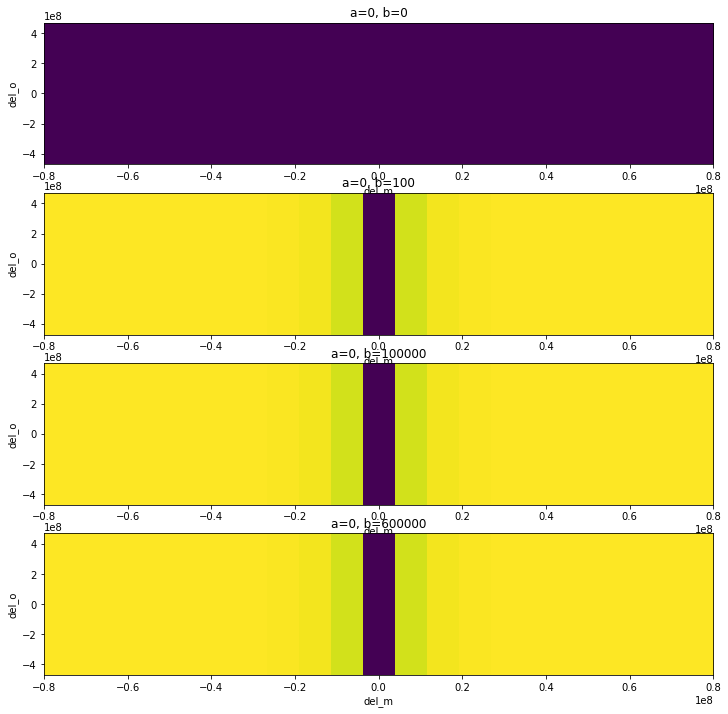

In [268]:
fig =plt.subplots(figsize=(12,12))
pltnum=1
im_lims=[min(delmvals),max(delmvals),min(delovals),max(delovals)]
for ii in range(1):
    for jj in range(4):
        sbplt=plt.subplot(4,1,pltnum)
        pltnum+=1
        sbplt.imshow(np.abs(boutvals_copy5[:,:,ii,jj]),extent=im_lims,aspect='auto',origin='lower')
        #sbplt.colorbar()
        plt.title('a=' + str(ainvals[ii])+ ', b=' + str(binvals[jj]) )
        plt.xlabel('del_m')
        plt.ylabel('del_o')
        

In [273]:
p['Omega']=0
delovals=[0]
delmvals=np.linspace(-0.1e8,0.1e8,201)
ainvals=[0]
binvals=[100]

aoutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_a=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
boutvals=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)
effic_b_twolevel=np.zeros((len(delovals),len(delmvals),len(ainvals),len(binvals)), dtype=np.complex_)

start_time=time.time()
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        for kk, ainval in enumerate(ainvals):
            for ll, binval in enumerate(binvals):
                if (ainval+binval) ==0:
                    print('zero lol')
                else:
                    aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                    effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                    effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                    effic_b_twolevel[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/binval
                    
                    elapsed_time=time.time()-start_time
                    print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                    print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in cdouble_scalars


    0, 0, 0, 0, Time: 17.21584963798523
    aout = 0j, bout = (-99.05356719214856-4.1841516563834755j)
    0, 1, 0, 0, Time: 34.398545265197754
    aout = 0j, bout = (-99.03530415538617-4.22224308562791j)
    0, 2, 0, 0, Time: 51.54037547111511
    aout = 0j, bout = (-99.01651690357498-4.260990896437487j)
    0, 3, 0, 0, Time: 68.69387626647949
    aout = 0j, bout = (-98.99718557029743-4.3004107566154435j)
    0, 4, 0, 0, Time: 86.03767013549805
    aout = 0j, bout = (-98.97728935917823-4.340518767674041j)
    0, 5, 0, 0, Time: 103.14959144592285
    aout = 0j, bout = (-98.9568064924217-4.381331475408073j)
    0, 6, 0, 0, Time: 120.28577923774719
    aout = 0j, bout = (-98.93571415609054-4.422865880359249j)
    0, 7, 0, 0, Time: 137.47301721572876
    aout = 0j, bout = (-98.91398844189628-4.465139448107188j)
    0, 8, 0, 0, Time: 154.66776752471924
    aout = 0j, bout = (-98.89160428525419-4.508170119313176j)
    0, 9, 0, 0, Time: 171.74771904945374
    aout = 0j, bout = (-98.868535399

    0, 80, 0, 0, Time: 1375.4587683677673
    aout = 0j, bout = (-89.08718566479646-9.649046291678133j)
    0, 81, 0, 0, Time: 1392.154543876648
    aout = 0j, bout = (-88.59947066451727-9.576266970137418j)
    0, 82, 0, 0, Time: 1408.7590072154999
    aout = 0j, bout = (-88.09468458511526-9.473948907096682j)
    0, 83, 0, 0, Time: 1425.6160261631012
    aout = 0j, bout = (-87.57424357646902-9.338763651593094j)
    0, 84, 0, 0, Time: 1442.3035995960236
    aout = 0j, bout = (-87.04007416385879-9.167272166192152j)
    0, 85, 0, 0, Time: 1459.007939338684
    aout = 0j, bout = (-86.49468218960135-8.955991926380866j)
    0, 86, 0, 0, Time: 1475.752609014511
    aout = 0j, bout = (-85.94121706950982-8.701485207122415j)
    0, 87, 0, 0, Time: 1492.5460152626038
    aout = 0j, bout = (-85.38352580904493-8.400470299342548j)
    0, 88, 0, 0, Time: 1509.2339825630188
    aout = 0j, bout = (-84.82618992963104-8.049956121089746j)
    0, 89, 0, 0, Time: 1527.5151679515839
    aout = 0j, bout = (-8

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in cdouble_scalars


    0, 100, 0, 0, Time: 1723.421412229538
    aout = 0j, bout = (-80.55555514331695+0j)
    0, 101, 0, 0, Time: 1741.9392039775848
    aout = 0j, bout = (-80.59348515630298+0.8579562272948604j)
    0, 102, 0, 0, Time: 1760.3438665866852
    aout = 0j, bout = (-80.70639248012863+1.7059292762124096j)
    0, 103, 0, 0, Time: 1778.5998132228851
    aout = 0j, bout = (-80.89167983827232+2.5343194551581796j)
    0, 104, 0, 0, Time: 1796.7961676120758
    aout = 0j, bout = (-81.14518259301636+3.334263530161475j)
    0, 105, 0, 0, Time: 1815.192929983139
    aout = 0j, bout = (-81.46139697774277+4.0979307446956605j)
    0, 106, 0, 0, Time: 1833.3891263008118
    aout = 0j, bout = (-81.83376667951751+4.818742819080665j)
    0, 107, 0, 0, Time: 1851.7675957679749
    aout = 0j, bout = (-82.25500120666896+5.491508091357834j)
    0, 108, 0, 0, Time: 1869.9692838191986
    aout = 0j, bout = (-82.71739933542393+6.11246941034672j)
    0, 109, 0, 0, Time: 1888.1396856307983
    aout = 0j, bout = (-83.

    0, 179, 0, 0, Time: 3059.757670402527
    aout = 0j, bout = (-98.52671535773874+5.145545036030009j)
    0, 180, 0, 0, Time: 3076.5884811878204
    aout = 0j, bout = (-98.56060778388343+5.090808580851555j)
    0, 181, 0, 0, Time: 3093.2489330768585
    aout = 0j, bout = (-98.59337378600458+5.037109086155812j)
    0, 182, 0, 0, Time: 3109.9236738681793
    aout = 0j, bout = (-98.62506138566998+4.984421860977273j)
    0, 183, 0, 0, Time: 3126.627135038376
    aout = 0j, bout = (-98.6557161482888+4.932722734915054j)
    0, 184, 0, 0, Time: 3143.3116178512573
    aout = 0j, bout = (-98.68538132720681+4.881988065948765j)
    0, 185, 0, 0, Time: 3159.9131371974945
    aout = 0j, bout = (-98.71409799844005+4.8321947452114555j)
    0, 186, 0, 0, Time: 3176.4467599391937
    aout = 0j, bout = (-98.74190518669845+4.78332019913871j)
    0, 187, 0, 0, Time: 3193.114067554474
    aout = 0j, bout = (-98.7688399833047+4.735342389362281j)
    0, 188, 0, 0, Time: 3209.6833624839783
    aout = 0j, bo

In [340]:
def find_outputs(ainvals,binvals,delovals,delmvals):
    aoutvals=np.zeros((len(ainvals),len(binvals),len(delovals),len(delmvals)), dtype=np.complex_)
    effic_a=np.zeros((len(ainvals),len(binvals),len(delovals),len(delmvals)), dtype=np.complex_)
    boutvals=np.zeros((len(ainvals),len(binvals),len(delovals),len(delmvals)), dtype=np.complex_)
    effic_b=np.zeros((len(ainvals),len(binvals),len(delovals),len(delmvals)), dtype=np.complex_)

    start_time=time.time()
    for ii, ainval in enumerate(ainvals):
        for jj, binval in enumerate(binvals):
                
            if (ainval+binval) ==0:
                print('zero lol')
            else:
                for kk, deloval in enumerate(delovals):
                    for ll, delmval in enumerate(delmvals):
                            aoutvals[ii,jj,kk,ll],boutvals[ii,jj,kk,ll]=find_output(ainval,binval,deloval,delmval)
                            effic_a[ii,jj,kk,ll]= aoutvals[ii,jj,kk,ll]/binval
                            effic_b[ii,jj,kk,ll]= boutvals[ii,jj,kk,ll]/ainval
                            elapsed_time=time.time()-start_time
                            print('    ' + str(ii) +', '+ str(jj)+ ', ' +str(kk) + ', ' +str(ll)+ ', Time: ' + str(elapsed_time)) 
                            print('    '+ 'aout = ' +str(aoutvals[ii,jj,kk,ll]) + ', bout = '+str(boutvals[ii,jj,kk,ll]))
    return aoutvals, boutvals,effic_a,effic_b

In [387]:
aoutvals1,boutvals1,effic_a1,effic_b1=find_outputs([0],[100000],np.linspace(-50e5,50e5,11),np.linspace(-5e5,5e5,3))

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in cdouble_scalars


    0, 0, 0, 0, Time: 45.89171481132507
    aout = (2.5560275268493752e-05+2.0654770955136376e-05j), bout = (-81461.39693926874-4097.930730773385j)
    0, 0, 0, 1, Time: 91.85983347892761
    aout = (4.221763920882999e-05-1.6058959881437136e-05j), bout = (-80555.55511540055-4.165577558426038e-05j)
    0, 0, 0, 2, Time: 137.77865934371948
    aout = (7.691804911716394e-06-2.9241443654971986e-05j), bout = (-81461.39697983967+4097.93073023725j)
    0, 0, 1, 0, Time: 183.7722110748291
    aout = (3.250335309557997e-05+2.5899904412485797e-05j), bout = (-81461.39693398411-4097.930732676091j)
    0, 0, 1, 1, Time: 230.1415820121765
    aout = (5.220869031759583e-05-2.0668911733091977e-05j), bout = (-80555.55511970886-5.100482612148986e-05j)
    0, 0, 1, 2, Time: 276.16933608055115
    aout = (9.521132297761121e-06-3.607663601415651e-05j), bout = (-81461.39698413335+4097.930731618864j)
    0, 0, 2, 0, Time: 323.1535291671753
    aout = (4.497641715986542e-05+3.3388821576957256e-05j), bout = (-

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in cdouble_scalars


    0, 0, 5, 1, Time: 771.990024805069
    aout = -0.00023716111943532857j, bout = (-80555.55532703208+0j)
    0, 0, 5, 2, Time: 818.3020706176758
    aout = (-0.0001313622919180941-0.00015945951343028115j), bout = (-81461.39700137223+4097.930853358449j)
    0, 0, 6, 0, Time: 864.4117527008057
    aout = (6.755459395406591e-07-0.00011158664317244549j), bout = (-81461.39702177414-4097.93076414244j)
    0, 0, 6, 1, Time: 910.2060124874115
    aout = (-0.00011445264672250496-0.00012056451525568211j), bout = (-80555.55521527838+0.00010995527280369462j)
    0, 0, 6, 2, Time: 956.218444108963
    aout = (-0.00014889749862431192+2.9346347433512932e-05j), bout = (-81461.39689080566+4097.930795577377j)
    0, 0, 7, 0, Time: 1002.8127243518829
    aout = (-1.2167420771194924e-05-6.724015164552009e-05j), bout = (-81461.39700201727-4097.930741225841j)
    0, 0, 7, 1, Time: 1048.6593158245087
    aout = (-9.037018755693812e-05-5.238705384289598e-05j), bout = (-80555.5551499632+8.711243536104614e-05

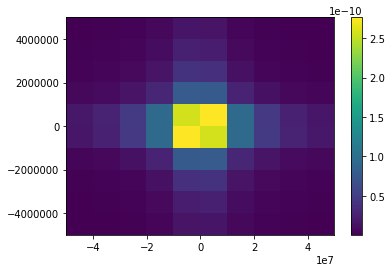

In [386]:
plt.imshow(np.abs(effic_a[0,1,:,:]),extent=(-50e6,50e6,-5e6,5e6),aspect='auto', origin='lower')
plt.colorbar()

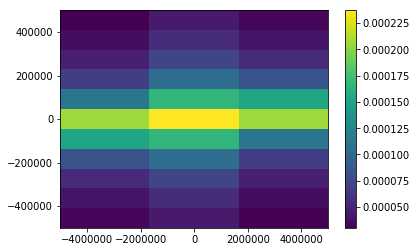

In [399]:
plt.imshow(np.abs(aoutvals1[0,0,:,:]),extent=(-5e6,5e6,-5e5,5e5),aspect='auto', origin='lower')
plt.colorbar()

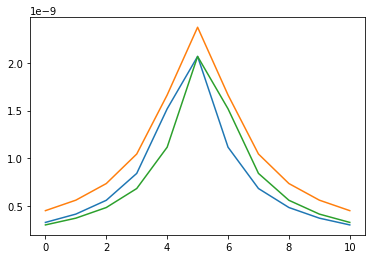

In [395]:
plt.plot(np.abs(effic_a1[0,0,:,:]))

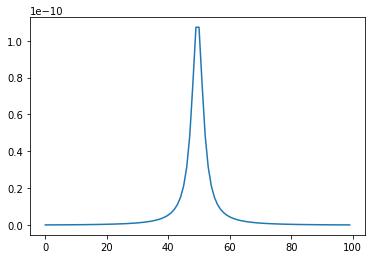

In [375]:
#plt.plot(np.abs(effic_b[1,0,:,:]))
plt.plot(np.abs(effic_2(np.linspace(-5e6,5e6,100))))
#plt.colorbar()

array([[1, 2],
       [3, 4],
       [5, 6]])

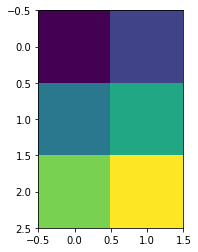

In [383]:
testmat=np.array([[1,2],[3,4],[5,6]])
testmat.shape
plt.imshow(testmat)
testmat

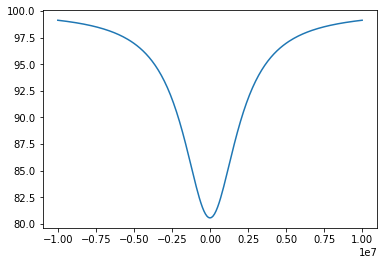

In [274]:
plt.plot(delmvals,np.abs(boutvals[0,:,0,0]))

In [297]:
boutvals[0,30:35,0,0]

array([-98.16163664-5.68914531j, -98.11317278-5.75570935j,
       -98.06283916-5.8236092j , -98.01054252-5.89287318j,
       -97.95618397-5.96352942j])

In [299]:
p

{'deltamu': 0.0,
 'deltao': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'go': 51.9,
 'No': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'mean_delam': 0,
 'sd_delam': 66700480.96793615,
 'mean_delao': 0,
 'sd_delao': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nm': 2.22e+16,
 'gm': 1.04,
 'gammaoc': 10681415.022205297,
 'gammaoi': 49951323.19207771,
 'gammamc': 439822.971502571,
 'gammami': 4084070.449666731,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqmu': 5186000000.0,
 'freq_pump': 195113360000000.0,
 'freqo': 195118546000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'Omega': 0}

In [276]:
p['No']*1e-16

In [322]:
S_no_detuning_integrand= lambda deloval, delmval: 1/(deloval*delmval-np.abs(p['Omega'])**2)*gauss_fun(deloval,delmval,p['mean_delao'], p['mean_delam'],p['sd_delao'],p['sd_delam'])
S_2=p['No']*p['Omega']*p['gm']*p['go']*scipy.integrate.nquad(S_no_detuning_integrand,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]

In [331]:
effic_2= lambda omega: np.abs(4*S_2*np.sqrt(p['gammamc']*p['gammaoc'])/(4*np.abs(S_2)**2(p['gammaoc']-2j*omega)*(p['gammamc']-2j*omega)))**2

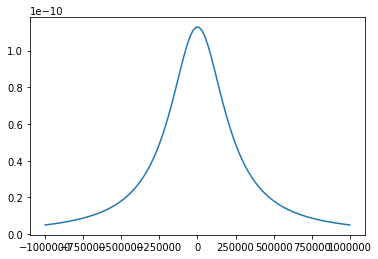

In [336]:
omegavals=np.linspace(-1e6,1e6,100)
plt.plot(omegavals,effic_2(omegavals))